# Trapped by Distance: How does house price growth increase commute time for lower-income workers in the United States?

# Project One

## Introduction

Over the past 20 years in the United States, sharply rising housing costs in urban cores have forced many low-income workers to move to suburban and rural areas, leading to longer commutes and increased transportation costs.  As affordable housing near job centers declines, workers suffer from time poverty, which refers to experiencing a lack of sufficient time to fulfill responsibilities, pursue interests, or engage in activities that contribute to one’s well-being due to various demands on their time (Travers,2024), as they must choose between paying high rent or suffering longer commute, reducing their time for work, family, and personal activities.

Previous studies have widely explored how house price growth influences commute time for lower-income workers in urban economics.  Blumenberg and Wander (2023) showed that rising housing costs in urban centers force low-income workers to relocate to suburban and exurban areas, which leads to longer commutes and increased reliance on public transportation.  This trend aggravated time poverty, where lower-income workers spend time commuting disproportionately, reducing the time available for work, education, and family (Blumenberg & King, 2019).  Also, Allen & Farber (2020) studied transport poverty and further emphasized how suburbanization limits job accessibility and increases travel costs, creating a cycle of economic hardship.  Additionally, economic cycles influence urban geography, with gentrification during boom periods accelerating displacement and commute burdens for low-income workers (Hochstenbach & Musterd, 2016).

However, the COVID-19 pandemic disrupted these patterns, as remote work adoption significantly reduced commute times for many workers, particularly higher-income individuals, reshaping the traditional relationship between housing costs and commuting. Studies across multiple countries found that 40-60% of workers shifted to home offices during lockdowns (Shibayama et al., 2021). In Israel, a 5-6% long-term reduction in commuting trips is expected post-pandemic (Ayelet Kogus et al., 2023). The Greater Sydney Metropolitan Area experienced a 54% reduction in commuting time costs, equating to $5.58 billion annually (Hensher et al., 2021). These changes have potential long-term sustainability benefits. A case study at MIT found that implementing a one-day-per-week work-from-home policy for staff could reduce car commuter miles by 16% (Berke et al., 2022). While the pandemic prompted a shift away from public transport due to infection concerns, many commuters also reported reduced travel times when switching to private cars or bicycles (Shibayama et al., 2021). Additionally, perceived COVID-19 risk and telecommuting productivity positively impact teleworking behavior (Mohammadi et al., 2022). These changes suggest a potential long-term shift in work patterns and commuting behaviors.

To understand these changes in social welfare, the research question we want to study is, “How does house price growth increase commute time for lower-income workers in the United States?”. We choose two datasets to answer this question: The Zillow dataset with historical and current housing market data at the county level; and IPUMS, the 2005 to 2023 USA census data at individual-level records. 

To explore this research question, we would choose **Commute Time** (The total time a worker travels to work) as the independent variable. The most important dependent variable would be the **Yearly House Price Growth Rate**(yearly percentage increase in home values in workers' working county) as essential for analyzing the research question. In addition, we find five more dependent variables, **Workers' Residence Metropolitan Status** (urban core, suburb, or non-metropolitan area) to find whether house prices push workers to reside in suburban or rural areas, **Work Transportation**(primary mode of commuting) to find if the county's public transportation is sufficient to relieve the commute pressure for the suburb workers, and departure time to work (hour workers leaves for work) to find whether low-income workers are forced to commute early, which decreases their daily personal time, and **Family Annual Income**, **Income Group** as economic indicators to control the observed effect.

Our findings find that before 2020, higher house price growth was associated with longer commute times, but after 2020, this relationship reversed, likely due to the rise of remote work. Additionally, lower-income workers continue to experience longer commutes, while public transportation significantly reduces commute times, especially post-pandemic.

## Data Cleaning/Loading

### Environment Setup

In [1]:
!pip install nbconvert --quiet

In [2]:
!pip install pyppeteer --quiet

In [3]:
! pip install -q qeds --quiet

In [4]:
!pip install geopandas -qq

In [5]:
!pip install us uszipcode -qq

In [81]:
import pandas as pd
import geopandas as gpd
import qeds
%matplotlib inline
import requests
from IPython.display import display
import datetime as dt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sm
from pandas_datareader import DataReader
import warnings
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML
from adjustText import adjust_text 
warnings.filterwarnings("ignore")

### Load Data

Load the housing market dataset.

In [7]:
file_path = "https://files.zillowstatic.com/research/public_csvs/\
zhvi/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1738696833"
hp = pd.read_csv(file_path)

Load the 2005 to 2023 US Census Data.

In [8]:
file_path = "/Users/shenxiner1/Downloads/ECO225/ECO225 \
Project/Data/usa_00024.csv.gz"
census_data = pd.read_csv(file_path, compression='gzip')
census_data = pd.DataFrame(census_data)

### Dataset Pre-Processing

Remove the County string from the Region Name variable for future merging.

In [9]:
hp['RegionName'] = hp['RegionName'].str.replace("County", "", regex=True).str.strip()

Convert the Date column in the reshaped DataFrame to a proper date format

In [10]:
id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 
           'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS']
hp_melted = pd.melt(hp, id_vars=id_vars, var_name='Date', 
                    value_name='Zillow Home Value Index (ZHVI)')
hp_melted['Date'] = pd.to_datetime(hp_melted['Date'], errors='coerce')
hp_melted['Year'] = hp_melted['Date'].dt.year
hp_melted['Year'] =hp_melted.Year.astype(int)

Processing the MULTYEAR variable to identify the actual year of the survey in multi-year ACS/PRCS samples, and drop observations with Commute Time equals 888, which was suppressed for data year 2023 for select PUMAs

In [11]:
census_data['MULTYEAR'] = census_data['MULTYEAR'].fillna(census_data['YEAR'])
census_data['MULTYEAR'] = census_data.MULTYEAR.astype(int)
census_data= census_data[census_data['TRANTIME'] != 888]
census_data= census_data[census_data['POVERTY'] != 0]

### Create New Columns

We create and encode new variables to standardize key variables from the Census and Housing data based on the data dictionary provided by IPUMS.

##### Yearly Growth Rate of Zillow Home Value Index (ZHVI) by County

We calculate the Yearly Growth Rate of House Value by comparing the Zillow Home Value Index (ZHVI) from January to December for each year and region, using the formula $\frac{\text{ZHVI}{\text{Dec}} - \text{ZHVI}{\text{Jan}}}{\text{ZHVI}_{\text{Jan}}} \times$ 100 .

In [12]:
hp_melted.sort_values(by=['RegionID', 'Date'], inplace=True)

january_data = hp_melted[hp_melted['Date'].dt.month == 1]
december_data = hp_melted[hp_melted['Date'].dt.month == 12]

yearly_data = pd.merge(january_data, december_data, on=['RegionID', 
                                                        'Year'], 
                       suffixes=('_start', '_end'))

yearly_data['Yearly_Growth_Rate'] = (
    (yearly_data['Zillow Home Value Index (ZHVI)_end'] - 
  yearly_data['Zillow Home Value Index (ZHVI)_start']) /
  yearly_data['Zillow Home Value Index (ZHVI)_start']) * 100
yearly_data = yearly_data[['RegionID', 'Year', 'Yearly_Growth_Rate']]
hp_meltedyear = pd.merge(hp_melted, yearly_data, on=['RegionID', 'Year'], how='left')
hp_meltedyear.drop(columns=['Date'], inplace=True)
hp_meltedyear = hp_meltedyear.drop_duplicates(subset=['RegionID', 'Year'], keep='first')
hp_meltedyear = hp_meltedyear.fillna(0)

We categorize Metropolitan Status based on IPUMS metropolitan classifications.

In [13]:
def categorize_metro(metro):
    """
    Categorizes the METRO variable into broader metropolitan classifications.
    
    Parameters:
    metro (int): METRO code.

    Returns:
    str: Categorical label for metropolitan classification.
    """
    if metro == 0:
        return "Metropolitan Status Indeterminable (Mixed)"
    elif metro == 1:
        return "Not in Metropolitan Area"
    elif metro == 2:
        return "In Central/Principal City"
    elif metro == 3:
        return "Not in Central/Principal City"
    elif metro == 4:
        return "Central/Principal City Status Indeterminable (Mixed)"
    else:
        return "Unknown"

census_data["METRO"] = census_data["METRO"].apply(categorize_metro)

We encoded TRANWORK codes into transportation categories.

In [14]:
category_mapping = {
    10: 'Vehicle',  # Auto, truck, or van
    20: 'Vehicle',  # Motorcycle
    31: 'Public Transport',  # Bus
    32: 'Public Transport',  # Bus or trolley bus
    36: 'Public Transport',  # Subway or elevated
    50: 'Public Transport',  # Bicycle
    60: 'Public Transport',  # Walked only
    80: 'Public Transport'   # Worked at home
}
census_data['Work Transportation'] = census_data['TRANWORK'].map(category_mapping)

We categorize the income level by poverty line as it's largely comparable across years. We categorize income levels based on the percentage above the poverty line, ensuring a structured comparison of economic groups.

In [15]:
income_bins = [0, 40000, 100000, 200000, float('inf')]
income_labels = ["Low Income", "Middle Income", 
                 "Upper Middle Income", "High Income"]

census_data["Income_Category"] = pd.cut(census_data["FTOTINC"], 
                                        bins=income_bins, 
                                        labels=income_labels, 
                                        include_lowest=True)
income_order = ["Low Income", "Middle Income", 
                "Upper Middle Income", "High Income"]
census_data["Income_Category"] = pd.Categorical(census_data["Income_Category"],
                                                categories=income_order, 
                                                ordered=True)

We classify DEPARTS into five departure time categories, assigning “Unknown” to missing or zero.

In [16]:
def categorize_departure_time(departs):
    if departs == 0 or pd.isna(departs):  
        return "Unknown"
    elif 1 <= departs <= 559:
        return "Very Early (Midnight - 6 AM)"
    elif 600 <= departs <= 859:
        return "Early Morning (6 AM - 9 AM)"
    elif 900 <= departs <= 1159:
        return "Mid-Morning (9 AM - 12 PM)"
    elif 1200 <= departs <= 1659:
        return "Afternoon (12 PM - 5 PM)"
    else:
        return "Evening/Night (5 PM - Midnight)"
census_data["DEPARTS_CATEGORY"] = census_data["DEPARTS"].apply(categorize_departure_time)


### Chekcing Missing Value

In [17]:
hp_meltedyear.isnull().sum()
hp_meltedyear = hp_meltedyear.dropna()

In [18]:
census_data.isnull().sum()
census_data = census_data.dropna()

We drop the census individual data with counties unidentifiable from public-use data to ensure data usability.

In [19]:
census_data= census_data[census_data['PWCOUNTY'] != 0]

### Merge Dataset by County

Our goal is to construct a dataset that records commute time for individuals included in the census sample across the United States from 2005 to 2023, with the yearly growth rate of house prices in the county where they worked.

To achieve this, we will merge two datasets: one containing yearly growth rate at the county level and another with commute time data from the census sample, both across 2005 to 2023. 

We merge two datasets by matching work state FIP Code, work County FIP Code, and year, linking each worker’s commute time with the average house price in their work location.

In [20]:
hp_meltedyear['PWSTATE2'] = hp_meltedyear['StateCodeFIPS'].astype(int)
hp_meltedyear['PWCOUNTY'] = hp_meltedyear['MunicipalCodeFIPS'].astype(int)
census_data['Year'] = census_data['MULTYEAR']
resultmerge = pd.merge(census_data,hp_meltedyear, on=['PWSTATE2','PWCOUNTY','Year'],how="left")
resultmerge.sort_values(by=['Year','RegionName'], inplace=True)

Finally, we check for missing values where housing data is unavailable for certain areas and drop those observations.

In [21]:
resultmerge.isnull().sum()
resultmerge = resultmerge.dropna()

### Filter Columns

In [22]:
resultmerge = resultmerge.rename(columns={'FTOTINC': 'Total Family Income'})
columns_to_keep = [
    'METRO', 'POVERTY', 'Work Transportation', 'Income_Category', 'DEPARTS_CATEGORY',
    'TRANTIME', 'DEPARTS', 'Total Family Income', 
    'Year', 'RegionName', 'State', 'Metro', 'Yearly_Growth_Rate',
    'PWSTATE2', 'PWCOUNTY', 'STATEFIP', 'COUNTYFIP'
]

resultmerge = resultmerge[columns_to_keep]

## Summary Statistics Tables

In [23]:
resultmergestat = resultmerge.rename(columns={
    "TRANTIME": "Commute Time",
    "POVERTY": "Percentage of Family's Poverty Threshold"
})

numerical_vars = ["Commute Time", "Yearly_Growth_Rate", 
                  "Total Family Income", "Percentage of Family's Poverty Threshold"]
merge_interest = resultmergestat[numerical_vars]

merge_interest.describe().T[['mean', 'std', 'count']].round(2)


,mean,std,count
Commute Time,26.95,23.13,1070841.0
Yearly_Growth_Rate,2.93,7.58,1070841.0
Total Family Income,116654.07,109417.26,1070841.0
Percentage of Family's Poverty Threshold,385.84,139.94,1070841.0


In [24]:
counts = resultmergestat['Income_Category'].value_counts(dropna=False)
proportions = counts / counts.sum()
    
pd.DataFrame({'Count': counts, 'Proportion': proportions.round(2)})

,Count,Proportion
Income_Category,,
Middle Income,419510,0.39
Upper Middle Income,337916,0.32
Low Income,180329,0.17
High Income,133086,0.12


In [25]:
counts = resultmergestat['METRO'].value_counts(dropna=False)
proportions = counts / counts.sum()
    
pd.DataFrame({'Count': counts, 'Proportion': proportions.round(2)})

,Count,Proportion
METRO,,
Not in Central/Principal City,703166,0.66
In Central/Principal City,317220,0.30
Not in Metropolitan Area,50455,0.05


#### Summary Statistics of numerical variables by Residence Metropolitan Status and Income Category

In [26]:
resultmergestat.groupby(["METRO"])[numerical_vars].agg([
    'mean', 'std', 'count']).round(2).T

METRO                                           In Central/Principal City  \
Commute Time                             mean                       26.60   
                                         std                        22.59   
                                         count                  317220.00   
Yearly_Growth_Rate                       mean                        3.14   
                                         std                         7.45   
                                         count                  317220.00   
Total Family Income                      mean                   108423.38   
                                         std                    118040.25   
                                         count                  317220.00   
Percentage of Family's Poverty Threshold mean                      360.50   
                                         std                       152.30   
                                         count                  317220.00   

METRO                                           Not in Central/Principal City  \
Commute Time                             mean                           26.51   
                                         std                            22.58   
                                         count                      703166.00   
Yearly_Growth_Rate                       mean                            2.89   
                                         std                             7.70   
                                         count                      703166.00   
Total Family Income                      mean                       122379.82   
                                         std                        107015.45   
                                         count                      703166.00   
Percentage of Family's Poverty Threshold mean                          398.71   
                                         std                           132.39   
                                         count                      703166.00   

METRO                                           Not in Metropolitan Area  
Commute Time                             mean                      35.31  
                                         std                       31.19  
                                         count                  50455.00  
Yearly_Growth_Rate                       mean                       2.13  
                                         std                        6.75  
                                         count                  50455.00  
Total Family Income                      mean                   88604.98  
                                         std                    72222.59  
                                         count                  50455.00  
Percentage of Family's Poverty Threshold mean                     365.74  
                                         std                      137.03  
                                         count                  50455.00

In [27]:
resultmergestat.groupby(["Income_Category"])[numerical_vars].agg(
    ['mean', 'std', 'count']).round(2).T

Income_Category                                 Low Income  Middle Income  \
Commute Time                             mean        25.94          27.03   
                                         std         22.92          22.82   
                                         count   180329.00      419510.00   
Yearly_Growth_Rate                       mean         2.55           2.72   
                                         std          8.03           7.81   
                                         count   180329.00      419510.00   
Total Family Income                      mean     24846.37       69359.82   
                                         std      10305.59       17064.68   
                                         count   180329.00      419510.00   
Percentage of Family's Poverty Threshold mean       160.29         369.68   
                                         std         80.50         108.00   
                                         count   180329.00      419510.00   

Income_Category                                 Upper Middle Income  \
Commute Time                             mean                 27.72   
                                         std                  23.45   
                                         count            337916.00   
Yearly_Growth_Rate                       mean                  3.13   
                                         std                   7.35   
                                         count            337916.00   
Total Family Income                      mean             139178.21   
                                         std               27443.01   
                                         count            337916.00   
Percentage of Family's Poverty Threshold mean                481.12   
                                         std                  48.72   
                                         count            337916.00   

Income_Category                                 High Income  
Commute Time                             mean         26.12  
                                         std          23.52  
                                         count    133086.00  
Yearly_Growth_Rate                       mean          3.59  
                                         std           6.70  
                                         count    133086.00  
Total Family Income                      mean     332940.81  
                                         std      163759.80  
                                         count    133086.00  
Percentage of Family's Poverty Threshold mean        500.46  
                                         std           7.00  
                                         count    133086.00

These tables show patterns in commute time, family income, and yearly housing price growth across metro areas and income levels.

Lower-income workers are moving to suburban areas, where they commute **26.51 minutes on average**, slightly less than in urban cores (**26.60 minutes**) but more than in rural areas (**35.31 minutes**). Suburban low-income workers also earn less (**Total Family Income $\$$24.8K**) than those in urban cores (**Total Family Income $\$$ 69.3K**). Meanwhile, housing prices have increased the most in urban areas (**3.14%**), more than in suburban (**2.89%**) and rural areas (**2.13%**). This suggests that rising workplace urban housing costs are pushing lower-income workers outward. As a result, they face longer commutes, increasing **time poverty** as they trade cheaper housing for more travel time.
Overall, the table highlights how lower-income workers are being priced out of cities, leading to **longer commutes and higher transportation costs** as they move to the suburbs.  

#### Count and proportion of residence Metro Type within each Income Category

In [28]:
count_df = resultmerge.groupby("Income_Category")["METRO"].value_counts().unstack()

proportion_df = resultmerge.groupby("Income_Category")["METRO"].value_counts(
    normalize=True).unstack() * 100
summary_df = count_df.astype(str) + " (" + proportion_df.round(2).astype(str) + "%)"
summary_df


METRO,In Central/Principal City,Not in Central/Principal City,Not in Metropolitan Area
Income_Category,,,
Low Income,75956 (42.12%),94847 (52.6%),9526 (5.28%)
Middle Income,123884 (29.53%),269700 (64.29%),25926 (6.18%)
Upper Middle Income,80368 (23.78%),244984 (72.5%),12564 (3.72%)
High Income,37012 (27.81%),93635 (70.36%),2439 (1.83%)


The table shows that most workers, regardless of income, live in suburban areas. Over half (53.62%) of low-income workers live in the suburbs, while only 41.12% remain in urban cores, suggesting that many lower-income individuals are priced out of city centers.  Meanwhile, non-metro areas have the smallest share of workers, with only 5-6% across all income levels, highlighting the dominance of suburban living, especially for lower-income households.

## Plots, Histograms, Figures

### Distribution of Household's Commute Time

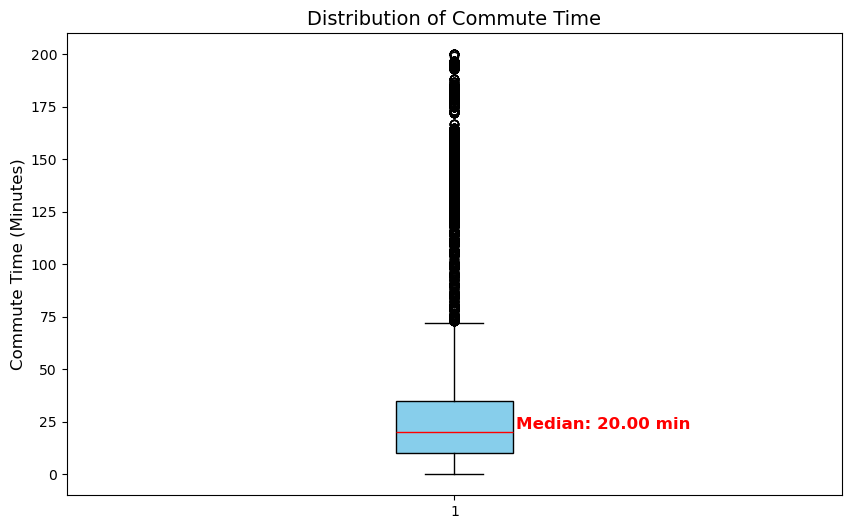

In [29]:
plt.figure(figsize=(10, 6))
plt.boxplot(resultmerge["TRANTIME"], patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
median_commute = np.median(resultmerge["TRANTIME"].dropna())
plt.text(1.08, median_commute, f'Median: {median_commute:.2f} min', 
         verticalalignment='bottom', color='red', fontsize=12, fontweight='bold')
plt.ylabel('Commute Time (Minutes)', fontsize=12)
plt.title('Distribution of Commute Time', fontsize=14)

plt.show()

From this plot, we find out that the median commute time is 20 minutes, while 75% of the households commute for about 40 minutes. Also, we can see that there are so many outliers exceeding 75 up to 200 minutes. This suggests a substantial group of extreme commuters, which verifies concerns about time poverty.

### Distribution of Yearly Growth Rate of Housing Value (Main Predictor) at Household’s Working County

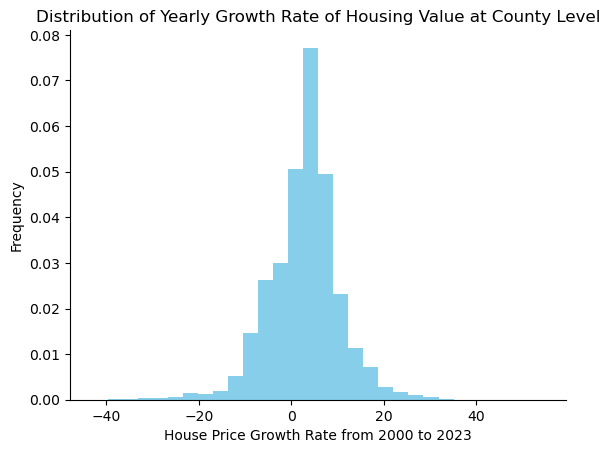

In [30]:
fig, ax = plt.subplots()
resultmerge.plot(
    kind="hist", y="Yearly_Growth_Rate", color='skyblue',
    bins=30, legend=False, density=True, ax=ax
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('House Price Growth Rate from 2000 to 2023')
plt.ylabel('Frequency')
plt.title('Distribution of Yearly Growth Rate of Housing Value at County Level')
plt.show()

This histogram shows that the yearly house price growth rates at the county level from 2000 to 2023 exhibit moderate growth rates centered around 0% for the majority of counties and years. However, there are notable cases of both negative and extreme positive growth rates, suggesting periods of housing market downturns and booms. 

### Relationship between Commute Time and Predictors

#### Yearly Growth Rate of Housing Value at Working County, Residence Metropolitan Status, Work Transportation

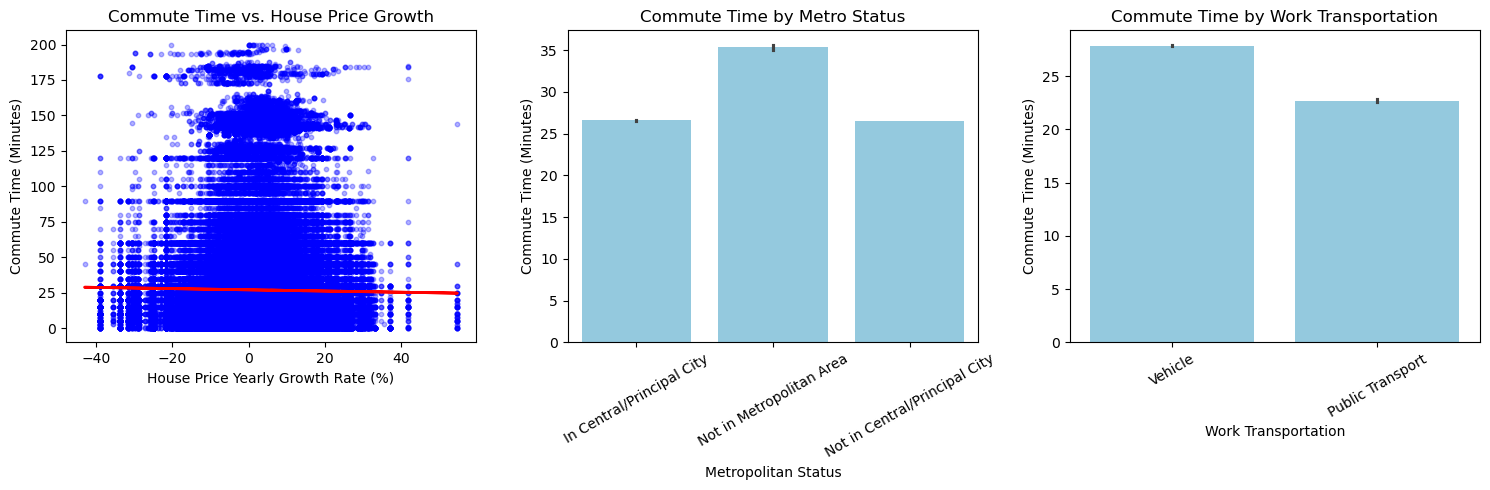

In [31]:
bar_color = "skyblue"
scatter_color = "blue"
line_color = "red"

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

X1 = resultmerge["Yearly_Growth_Rate"].values.reshape(-1, 1)
y1 = resultmerge["TRANTIME"].values.reshape(-1, 1)
lr1 = LinearRegression().fit(X1, y1)
y_pred1 = lr1.predict(X1)

axes[0].scatter(resultmerge["Yearly_Growth_Rate"], resultmerge["TRANTIME"], 
                color=scatter_color, alpha=0.3, s=10)
axes[0].plot(resultmerge["Yearly_Growth_Rate"], y_pred1, 
             color=line_color, linewidth=2)
axes[0].set_title("Commute Time vs. House Price Growth")
axes[0].set_xlabel("House Price Yearly Growth Rate (%)")
axes[0].set_ylabel("Commute Time (Minutes)")

sns.barplot(data=resultmerge, x="METRO", y="TRANTIME", ax=axes[1],
            color=bar_color)
axes[1].set_title("Commute Time by Metro Status")
axes[1].set_xlabel("Metropolitan Status")
axes[1].set_ylabel("Commute Time (Minutes)")
axes[1].tick_params(axis='x', rotation=30)

sns.barplot(data=resultmerge, x="Work Transportation", y="TRANTIME", 
            ax=axes[2], color=bar_color)
axes[2].set_title("Commute Time by Work Transportation")
axes[2].set_xlabel("Work Transportation")
axes[2].set_ylabel("Commute Time (Minutes)")
axes[2].tick_params(axis='x', rotation=30)


plt.tight_layout()
plt.show()

#### Departure Hour, Annual Family Income, Poverty Level

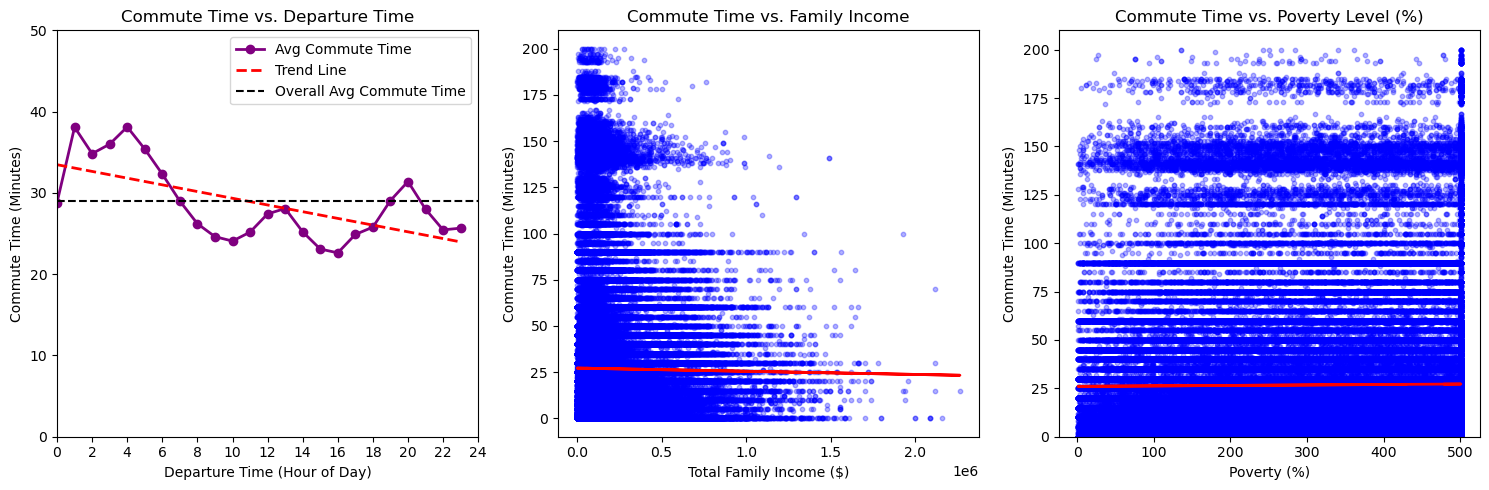

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

df = resultmerge[(resultmerge["DEPARTS"] != 0) & (~resultmerge["DEPARTS"].isna())].copy()

df["DEPARTS_HOUR"] = df["DEPARTS"] // 100  

departure_avg = df.groupby("DEPARTS_HOUR")["TRANTIME"].mean().reset_index()

X0 = departure_avg["DEPARTS_HOUR"].values.reshape(-1, 1)
y0 = departure_avg["TRANTIME"].values.reshape(-1, 1)
lr0 = LinearRegression().fit(X0, y0)
y_pred0 = lr0.predict(X0)

axes[0].plot(departure_avg["DEPARTS_HOUR"], departure_avg["TRANTIME"], 
             color="purple", marker="o", linestyle="-", linewidth=2, label="Avg Commute Time")

axes[0].plot(departure_avg["DEPARTS_HOUR"], y_pred0, color="red", linestyle="--", linewidth=2, label="Trend Line")

axes[0].set_title("Commute Time vs. Departure Time")
axes[0].set_xlabel("Departure Time (Hour of Day)")
axes[0].set_ylabel("Commute Time (Minutes)")
axes[0].set_xticks(range(0, 25, 2)) 
axes[0].set_xlim(0, 24) 
axes[0].set_ylim(0, 50)
axes[0].axhline(y=df["TRANTIME"].mean(), 
                color="black", linestyle="--", 
                label="Overall Avg Commute Time")
axes[0].legend()

X1 = resultmerge["Total Family Income"].values.reshape(-1, 1)
y1 = resultmerge["TRANTIME"].values.reshape(-1, 1)
lr1 = LinearRegression().fit(X1, y1)
y_pred1 = lr1.predict(X1)

axes[1].scatter(resultmerge["Total Family Income"], 
                resultmerge["TRANTIME"], 
                color=scatter_color, alpha=0.3, s=10)

axes[1].plot(resultmerge["Total Family Income"],
             y_pred1, color=line_color, linewidth=2)

axes[1].set_title("Commute Time vs. Family Income")
axes[1].set_xlabel("Total Family Income ($)")
axes[1].set_ylabel("Commute Time (Minutes)")

resultmerge_poverty = resultmerge[resultmerge['POVERTY'] != 0]
X2 = resultmerge_poverty["POVERTY"].values.reshape(-1, 1)
y2 = resultmerge_poverty["TRANTIME"].values.reshape(-1, 1)
lr2 = LinearRegression().fit(X2, y2)
y_pred2 = lr2.predict(X2)

axes[2].scatter(resultmerge_poverty["POVERTY"], 
                resultmerge_poverty["TRANTIME"], 
                color=scatter_color,
                alpha=0.3, s=10)
axes[2].plot(resultmerge_poverty["POVERTY"], 
             y_pred2, color=line_color, linewidth=2)
axes[2].set_title("Commute Time vs. Poverty Level (%)")
axes[2].set_xlabel("Poverty (%)")
axes[2].set_ylabel("Commute Time (Minutes)")
axes[2].set_ylim(0, 210)

plt.tight_layout()
plt.show()

The above six graphs show the relationship between commute time and key predictors.  The scatter plots state that as the percentage above the poverty line and the house price growth rate increase, commute times tend to slightly rise, while the increase in total family income significantly decreases the commute time.  The line chart on departure time shows that workers who depart to work early in the day experience longer commutes, much higher than the average commute time, and the average commute time tends to decrease at the later hour of the day.   The bar charts of ways workers transport to work and the metropolitan status of workers' residences further highlight differences in commute times.  Workers who commute by car have longer commute times, which shows that developing public transportation might be a good way to decrease the commute pressure for workers.  Also, the workers living in the suburbs have significantly higher commute pressure than those living in the urban core.  This suggests that rising house prices may increase commuting pressure by pushing workers out of urban cores into suburban areas. This finding aligns with our literature review, which highlights that suburban residents typically face longer commute times, exacerbating time scarcity and limiting their economic and social mobility.

### Impact of Working County Housing Price Growth on Commute Time by Income Levels

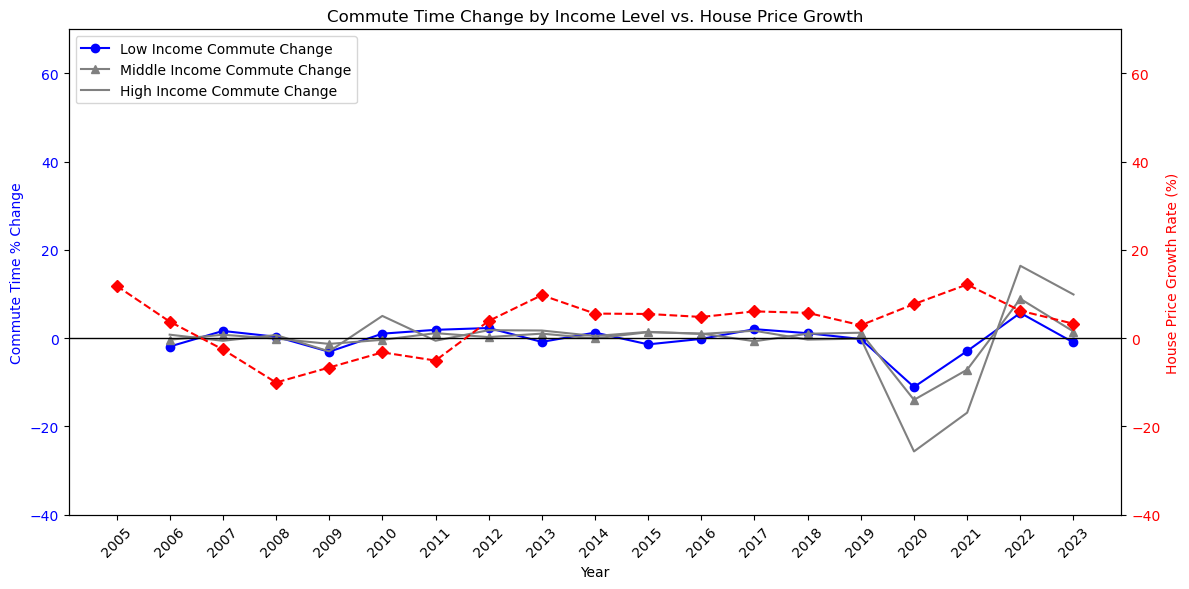

In [33]:
yearly_commute = resultmerge.groupby(["Year", "Income_Category"])["TRANTIME"].mean().unstack()

yearly_commute_change = yearly_commute.pct_change() * 100

yearly_growth = resultmerge.groupby("Year")["Yearly_Growth_Rate"].mean()
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yearly_commute_change.index, yearly_commute_change["Low Income"], 
         color="blue", marker="o", linestyle="-", label="Low Income Commute Change")
ax1.plot(yearly_commute_change.index, yearly_commute_change["Middle Income"], 
         color="grey", marker="^",linestyle="-", label="Middle Income Commute Change")
ax1.plot(yearly_commute_change.index, yearly_commute_change["High Income"], 
         color="grey", linestyle="-", label="High Income Commute Change")

ax1.set_xlabel("Year")
ax1.set_ylabel("Commute Time % Change", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(-40, 70) 

ax2 = ax1.twinx()
ax2.plot(yearly_growth.index, yearly_growth, 
         color="red", marker="D", linestyle="--")
ax2.set_ylabel("House Price Growth Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(-40, 70) 

plt.title("Commute Time Change by Income Level vs. House Price Growth")
ax1.axhline(0, color='black', linestyle='-', linewidth=1)  # **Zero reference line**


ax1.set_xticks(yearly_commute_change.index)
ax1.set_xticklabels(yearly_commute_change.index, rotation=45)

ax1.legend(loc="upper left")
plt.savefig("commute_vs_price_growth.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


This graph compares the trend of percentage change in commute time for different income groups with the house price growth rate. We find out that low-income workers experience more fluctuations in commute time changes, suggesting that they are more sensitive to housing price shifts compared with middle and high income workers. Notably, when house price growth rises, low-income workers’ commute times tend to increase more compared to other income groups, indicating a possible displacement effect—higher housing costs may be pushing them farther from job centers. This aligns with our idea that rising house prices affect lower-income workers by forcing them into longer commutes and time poverty. 

### Family Income and Low-Income Worker Proportion by Departure Time for Work

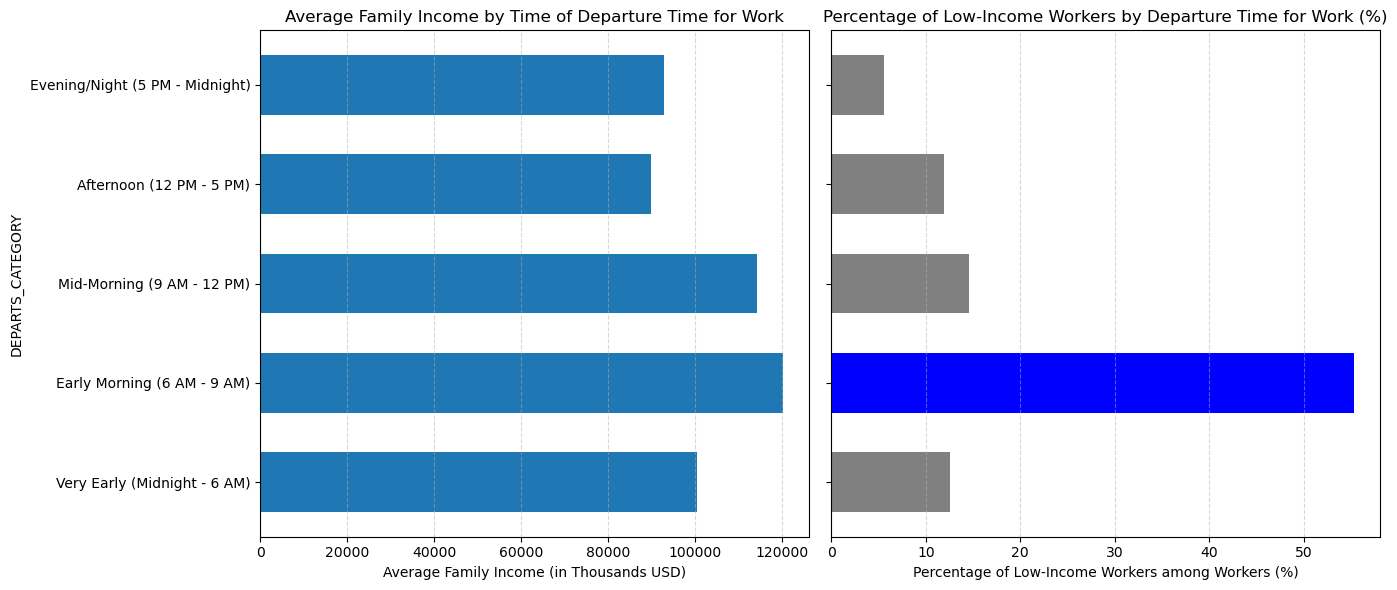

In [34]:
category_order = [
    "Very Early (Midnight - 6 AM)",
    "Early Morning (6 AM - 9 AM)",
    "Mid-Morning (9 AM - 12 PM)",
    "Afternoon (12 PM - 5 PM)",
    "Evening/Night (5 PM - Midnight)",
]

resultmerge_filtered = resultmerge[resultmerge["DEPARTS"] != 0]
resultmerge_filtered["DEPARTS_CATEGORY"] = pd.Categorical(resultmerge_filtered["DEPARTS_CATEGORY"], 
                                                          categories=category_order, ordered=True)

income_by_departure = resultmerge_filtered.groupby("DEPARTS_CATEGORY")["Total Family Income"].mean()

departure_income_counts = resultmerge_filtered[resultmerge_filtered["Income_Category"] 
== "Low Income"].groupby("DEPARTS_CATEGORY").size()
departure_income_percentage = (departure_income_counts / departure_income_counts.sum()) * 100

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

income_by_departure.plot(kind="barh", ax=ax[0], width=0.6)
ax[0].set_xlabel("Average Family Income (in Thousands USD)")
ax[0].set_title("Average Family Income by Time of Departure Time for Work")
ax[0].grid(axis="x", linestyle="--", alpha=0.5)

colors = ["grey"] * len(departure_income_counts)
colors[1] = "blue" 

departure_income_percentage.plot(kind="barh", ax=ax[1], color=colors, width=0.6)
ax[1].set_xlabel("Percentage of Low-Income Workers among Workers (%)")
ax[1].set_title("Percentage of Low-Income Workers by Departure Time for Work (%)")
ax[1].grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The graph shows how family income and the percentage of low-income workers vary by departure time for work. 
From the two graphs, we can see that low-income workers are more likely to leave for work early in the morning, possibly due to longer travel times caused by reliance on public transportation or jobs located far from affordable housing, and those who depart early tend to have lower incomes. This connection suggests that long commutes and early departures contribute to time poverty, leaving workers with less time for rest, family, or skill-building. As a result, it becomes harder for them to improve their financial situation and escape the cycle of low income.

# Project Two

## The Message

Our project tries to answer the research question: "How does house price growth increase commute time for lower-income workers in the United States?"

From the visualization, we notice that the relationship between house price growth and commute time for low-income workers evolved over time—it was moderately positive before COVID-19, indicating that rising house prices in working places were associated with longer commutes, but after the pandemic, the trend became negative, suggesting that rising house prices may now reduce commute times, potentially due to remote work adoption.

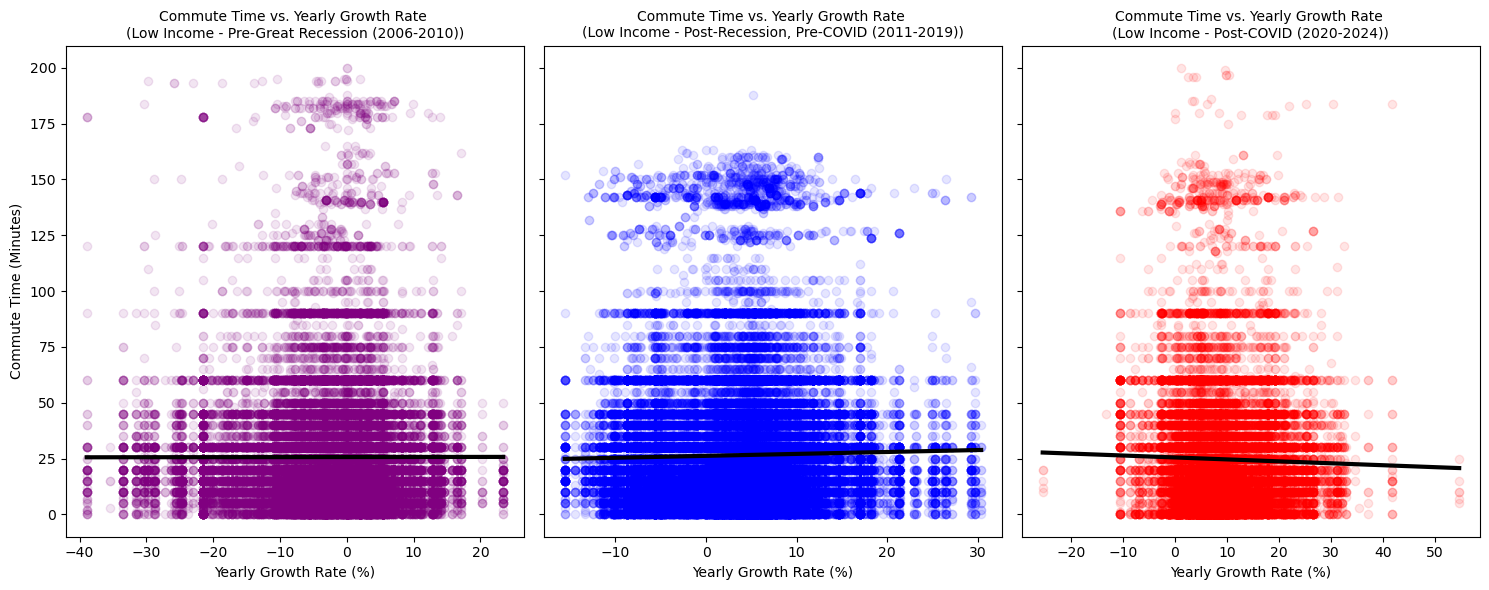

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

covid_palette = {
    "Pre-Great Recession (2006-2010)": "purple",
    "Post-Recession, Pre-COVID (2011-2019)": "blue",
    "Post-COVID (2020-2024)": "red"
}


low_income_data = resultmerge[resultmerge["Income_Category"] == "Low Income"].copy()

def assign_period(year):
    if 2006 <= year <= 2010:
        return "Pre-Great Recession (2006-2010)"
    elif 2011 <= year <= 2019:
        return "Post-Recession, Pre-COVID (2011-2019)"
    else:
        return "Post-COVID (2020-2024)"

low_income_data["Economic_Period"] = low_income_data["Year"].apply(assign_period)


period_order = ["Pre-Great Recession (2006-2010)", "Post-Recession, Pre-COVID (2011-2019)", 
                "Post-COVID (2020-2024)"]
low_income_data["Economic_Period"] = pd.Categorical(low_income_data["Economic_Period"],
                                                    categories=period_order, ordered=True)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)


economic_periods = ["Pre-Great Recession (2006-2010)", "Post-Recession, Pre-COVID (2011-2019)",
                    "Post-COVID (2020-2024)"]
colors = ["purple", "blue", "red"]


for i, (period, color) in enumerate(zip(economic_periods, colors)):
    subset = low_income_data[low_income_data["Economic_Period"] == period]
    
    axes[i].scatter(subset["Yearly_Growth_Rate"], subset["TRANTIME"], alpha=0.1, 
                    color=color, label=f"{period} Data")
    
    X = subset["Yearly_Growth_Rate"]
    y = subset["TRANTIME"]
    
    if len(X) > 1:  
        X = sm.add_constant(X) 
        model = sm.OLS(y, X).fit()
        X_pred = np.linspace(X["Yearly_Growth_Rate"].min(), 
                             X["Yearly_Growth_Rate"].max(), 100)
        X_pred_const = sm.add_constant(X_pred)
        y_pred = model.predict(X_pred_const)
        
        axes[i].plot(X_pred, y_pred, color='black', linewidth=3, 
                     label="Fitted Line")

    axes[i].set_title(f"Commute Time vs. Yearly Growth Rate \n(Low Income - {period})", 
                      fontsize=10)
    axes[i].set_xlabel("Yearly Growth Rate (%)", fontsize=10)
    if i == 0:
        axes[i].set_ylabel("Commute Time (Minutes)", fontsize=10)
    
   
    axes[i].set_facecolor("white")


plt.tight_layout()


fig.patch.set_facecolor('white')

plt.show()

## Maps and Interpretations

In [36]:
county = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip")
county = county.to_crs(epsg=4326)

In [37]:
county['PWSTATE2']= county['STATEFP']
county['PWCOUNTY'] = county['COUNTYFP']
resultmerge['PWSTATE2'] = resultmerge['PWSTATE2'].astype(int)
resultmerge['PWCOUNTY'] = resultmerge['PWCOUNTY'].astype(int)

county['PWSTATE2'] = county['PWSTATE2'].astype(int)
county['PWCOUNTY'] = county['PWCOUNTY'].astype(int)
resultmergemap = pd.merge(resultmerge,county, 
                          on=['PWSTATE2','PWCOUNTY'],how="left")
resultmergemap = resultmergemap.dropna()

In [38]:
county['PWSTATE2']= county['STATEFP']
county['PWCOUNTY'] = county['COUNTYFP']
hp_meltedyear['PWSTATE2'] = hp_meltedyear['PWSTATE2'].astype(int)
hp_meltedyear['PWCOUNTY'] = hp_meltedyear['PWCOUNTY'].astype(int)

county['PWSTATE2'] = county['PWSTATE2'].astype(int)
county['PWCOUNTY'] = county['PWCOUNTY'].astype(int)
hp_meltedyearmap = pd.merge(hp_meltedyear,county, 
                          on=['PWSTATE2','PWCOUNTY'],how="left")
hp_meltedyearmap = hp_meltedyearmap.dropna()

### Yearly Growth Rate of House Prices by County (%)

In [39]:
avg_growth_rate_by_county = hp_meltedyearmap.groupby(
    ['STATEFP','COUNTYFP'], as_index=False).agg(
    {'Yearly_Growth_Rate': 'mean', 'geometry': 'first'}  
)

avg_growth_rate_by_county = gpd.GeoDataFrame(avg_growth_rate_by_county, 
                                             geometry='geometry')

mainland_fips = [
    '01', '04', '05', '06', '08', '09', '10', '12', '13', '16', '17', '18', '19', '20', 
    '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', 
    '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', 
    '50', '51', '53', '54', '55', '56'
]
mainavg_growth_rate_by_county= avg_growth_rate_by_county[avg_growth_rate_by_county['STATEFP']\
.isin(mainland_fips)].copy()

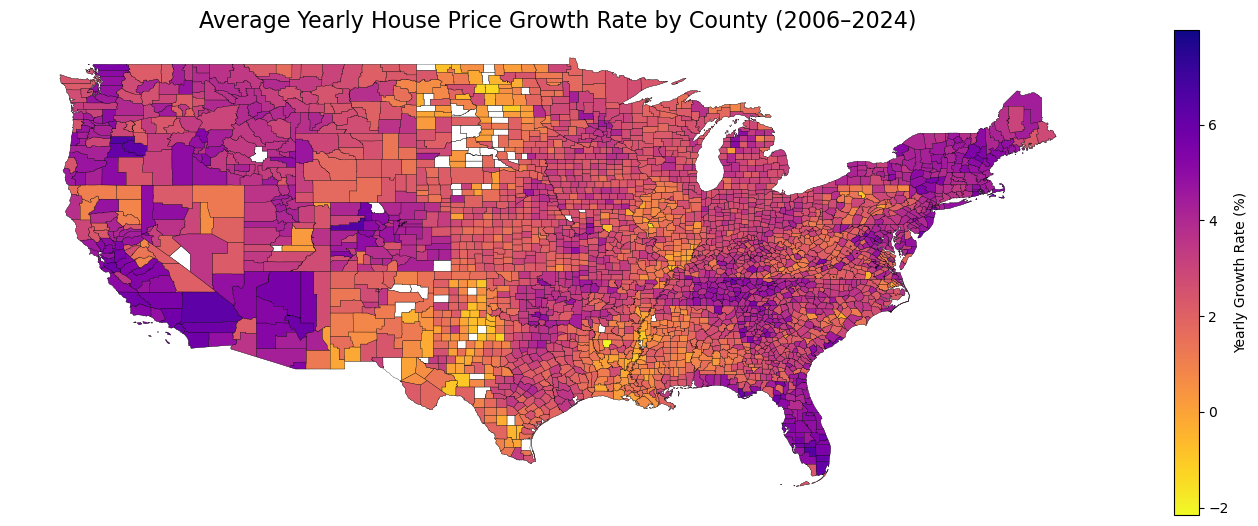

In [40]:
county_main = county[county['STATEFP'].isin(mainland_fips)].copy()

vmin = mainavg_growth_rate_by_county["Yearly_Growth_Rate"].min()
vmax = mainavg_growth_rate_by_county["Yearly_Growth_Rate"].max()

fig, ax = plt.subplots(figsize=(14, 10))

county_main.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

mainavg_growth_rate_by_county.plot(
    column='Yearly_Growth_Rate',
    cmap='plasma_r',
    linewidth=0.2,
    edgecolor='black',
    legend=True,
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={'shrink': 0.5, 'label': "Yearly Growth Rate (%)"}
)

ax.set_title("Average Yearly House Price Growth Rate by County (2006–2024)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

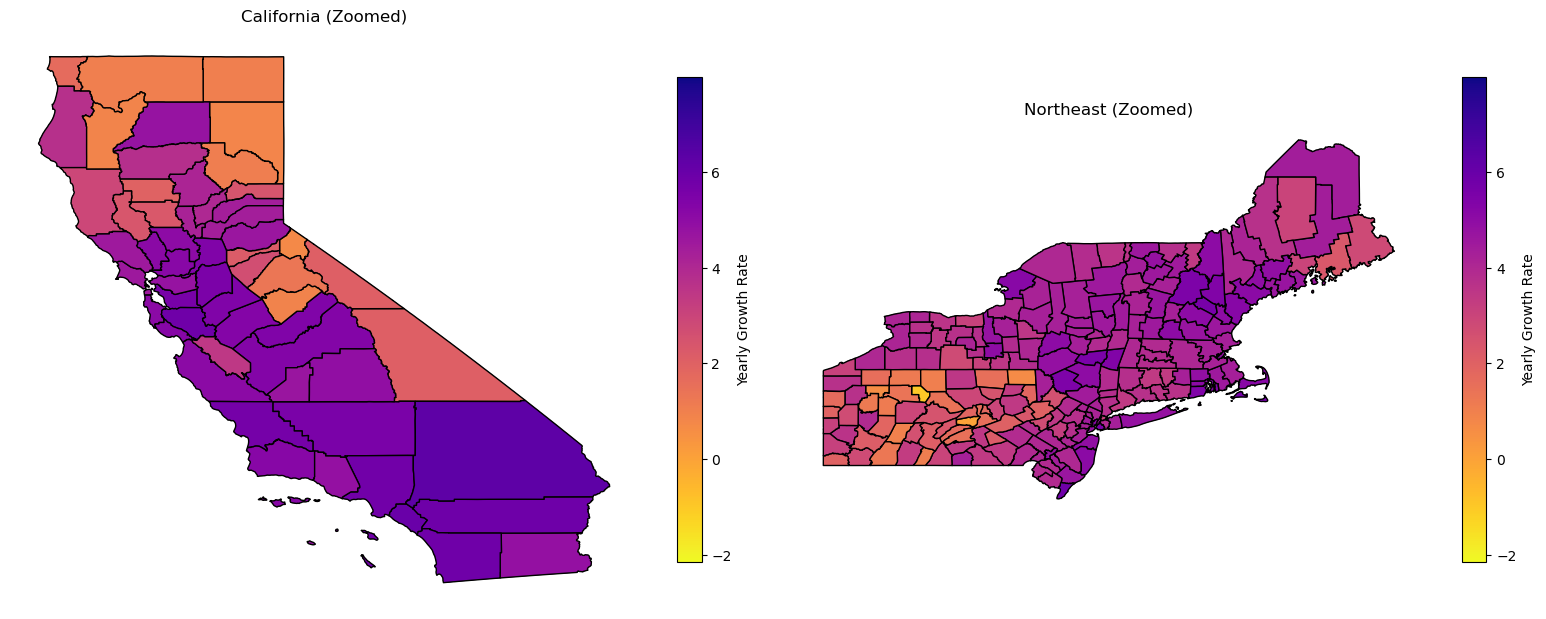

In [43]:
fig, (ax_california, ax_northeast) = plt.subplots(1, 2, figsize=(16, 10), 
                                                  gridspec_kw={'width_ratios': [1.5, 1.5]})
growth_california = mainavg_growth_rate_by_county[mainavg_growth_rate_by_county['STATEFP']== "06"]
county_main[county_main['STATEFP'] == '06'].plot(
    ax=ax_california, edgecolor='black', facecolor='none', linewidth=0.3)
growth_california.plot(
    column='Yearly_Growth_Rate', cmap='plasma_r', edgecolor='black', legend=True,
    vmin=vmin, vmax=vmax, ax=ax_california,
    legend_kwds={'shrink': 0.5, 'label': "Yearly Growth Rate"})
ax_california.set_axis_off()
ax_california.set_title("California (Zoomed)", fontsize=12)


northeast_fips = ['09', '23', '25', '33', '34', '36', '42', '44', '50']  

county_northeast = county[county['STATEFP'].isin(northeast_fips)].copy()
growth_northeast = mainavg_growth_rate_by_county[mainavg_growth_rate_by_county['STATEFP'].isin(northeast_fips)]

county_northeast.plot(ax=ax_northeast, edgecolor='black', facecolor='none', linewidth=0.3)
growth_northeast.plot(
    column='Yearly_Growth_Rate', cmap='plasma_r', edgecolor='black', legend=True,
    vmin=vmin, vmax=vmax, ax=ax_northeast,
    legend_kwds={'shrink': 0.5, 'label': "Yearly Growth Rate"})
ax_northeast.set_axis_off()
ax_northeast.set_title("Northeast (Zoomed)", fontsize=12)

plt.tight_layout()
plt.show()

These maps highlight regional disparities in house price growth across U.S. counties from 2006 to 2024, with the highest increases concentrated in urban and coastal regions, especially California, the Northeast, and parts of the South. We zoom in on California and the Northeast due to their high population density, economic importance, and extensive commuting networks into major cities like Los Angeles, San Francisco, New York, Washington, DC, and Philadelphia. These regions also face distinct housing market pressures.

California, long associated with a housing affordability crisis, shows stark contrasts: coastal urban counties like the Bay Area and Los Angeles exhibit the fastest growth, while inland and rural counties show slower rates, signaling weaker demand. In contrast, the Northeast reveals more fragmented growth—concentrated in metropolitan hubs but tapering in peripheral counties—reflecting a combination of economic disparities and infrastructure constraints. By comparing the two, we observe that California’s growth is geographically concentrated, whereas the Northeast reflects a blend of urban and inter-state commuter-driven expansion.

### Difference in Average Commute Time Between High- and Low-Income Workers by County (Minutes)

In [44]:
avg_commute_by_county_low = resultmergemap\
.query("Income_Category == 'Low Income'").groupby(
    ['PWSTATE2', 'PWCOUNTY', 'STATEFP'], 
    as_index=False).agg({'TRANTIME': 'mean', 'geometry': 'first'})

avg_commute_by_county_high = resultmergemap.\
query("Income_Category == 'High Income'").groupby(
    ['PWSTATE2', 
     'PWCOUNTY', 'STATEFP'], 
    as_index=False).agg({'TRANTIME': 'mean', 'geometry': 'first'})

mainavg_commute_by_county_low= avg_commute_by_county_low[avg_commute_by_county_low['STATEFP']\
.isin(mainland_fips)].copy()
commute_california_low = mainavg_commute_by_county_low[mainavg_commute_by_county_low['STATEFP'] == '06']

mainavg_commute_by_county_high= avg_commute_by_county_high[avg_commute_by_county_high['STATEFP']\
.isin(mainland_fips)].copy()
commute_california_high = mainavg_commute_by_county_high[mainavg_commute_by_county_high['STATEFP'] == '06']

mainavg_commute_by_county_low = gpd.GeoDataFrame(mainavg_commute_by_county_low, 
                                                 geometry='geometry')

commute_california_low = gpd.GeoDataFrame(commute_california_low, 
                                          geometry='geometry')

mainavg_commute_by_county_high = gpd.GeoDataFrame(mainavg_commute_by_county_high, 
                                                  geometry='geometry')
commute_california_high = gpd.GeoDataFrame(commute_california_high, 
                                           geometry='geometry')

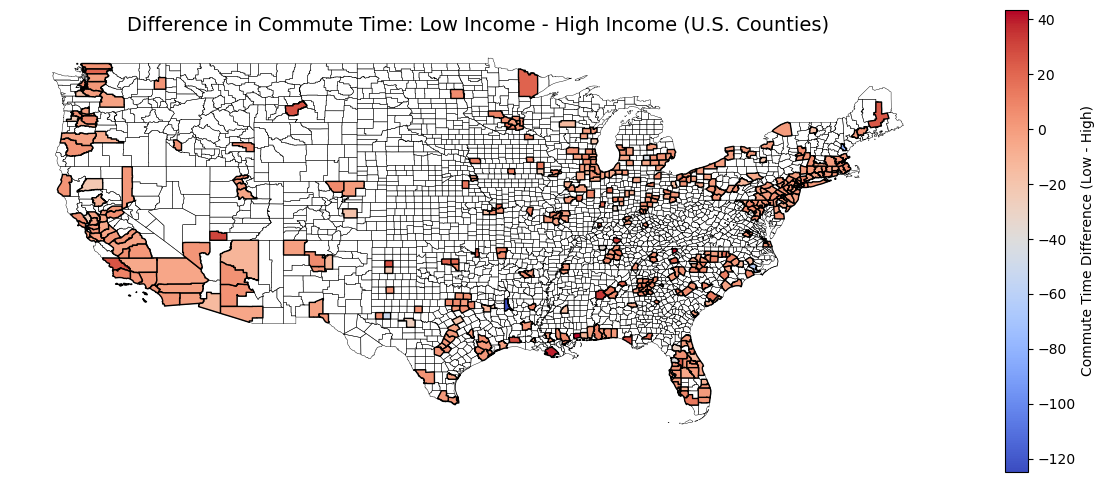

In [45]:
commute_diff = pd.merge(
    mainavg_commute_by_county_high[['PWSTATE2', 'PWCOUNTY', 'TRANTIME', 'geometry','STATEFP']],
    mainavg_commute_by_county_low[['PWSTATE2', 'PWCOUNTY', 'TRANTIME','STATEFP']],
    on=['STATEFP', 'PWCOUNTY'],
    suffixes=('_high', '_low')
)

commute_diff['Commute_Diff'] = commute_diff['TRANTIME_low'] - commute_diff['TRANTIME_high']

commute_diff = gpd.GeoDataFrame(commute_diff, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
county_main.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.3)
commute_diff.plot(
    column='Commute_Diff',
    cmap='coolwarm',  # Blue = low-income longer, Red = high-income longer
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Commute Time Difference (Low - High)", 'shrink': 0.6},
    ax=ax
)
ax.set_axis_off()
ax.set_title("Difference in Commute Time: Low Income - High Income (U.S. Counties)", fontsize=14)
plt.savefig("mapdiff.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

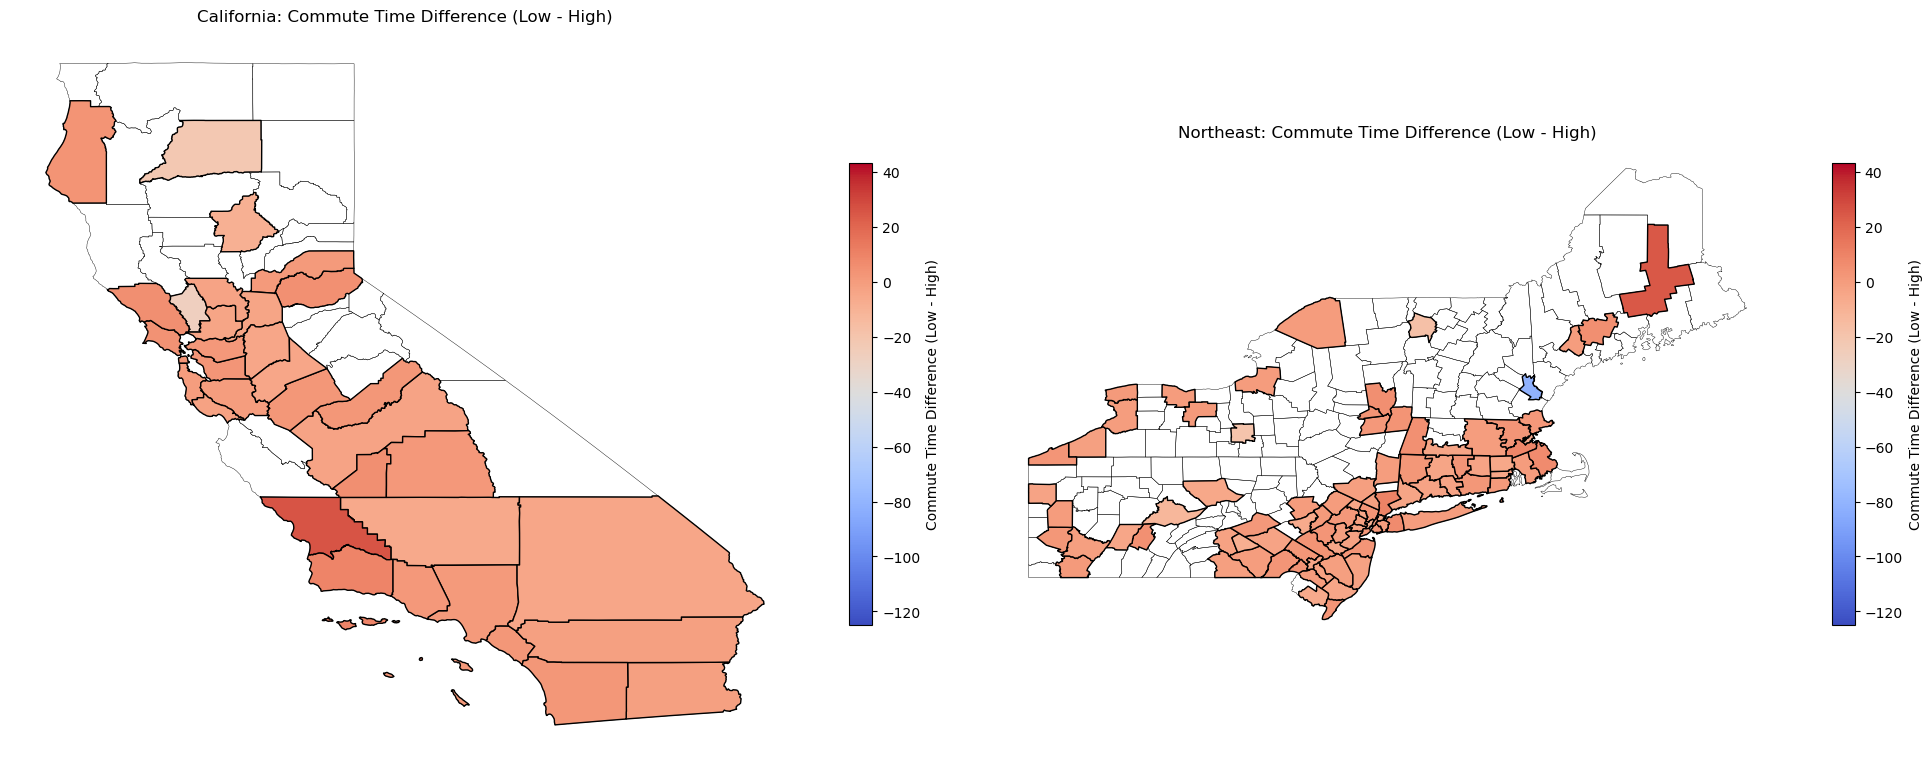

In [46]:
northeast_fips = ['09', '23', '25', '33', '34', '36', '42', '44', '50']  # CT, ME, MA, NH, NJ, NY, PA, RI, VT
california_fips = ['06']

commute_diff_california = commute_diff[commute_diff['STATEFP'].isin(california_fips)]
commute_diff_northeast = commute_diff[commute_diff['STATEFP'].isin(northeast_fips)]


county_california = county_main[county_main['STATEFP'].isin(california_fips)]
county_northeast = county_main[county_main['STATEFP'].isin(northeast_fips)]

vmin = commute_diff['Commute_Diff'].min()
vmax = commute_diff['Commute_Diff'].max()

fig, (ax_ca, ax_ne) = plt.subplots(1, 2, figsize=(20, 8))

county_california.plot(ax=ax_ca, edgecolor='black', facecolor='none', linewidth=0.3)
commute_diff_california.plot(
    column='Commute_Diff',
    cmap='coolwarm',
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Commute Time Difference (Low - High)", 'shrink': 0.6},
    vmin=vmin,
    vmax=vmax,
    ax=ax_ca
)
ax_ca.set_axis_off()
ax_ca.set_title("California: Commute Time Difference (Low - High)", fontsize=12)

county_northeast.plot(ax=ax_ne, edgecolor='black', facecolor='none', linewidth=0.3)
commute_diff_northeast.plot(
    column='Commute_Diff',
    cmap='coolwarm',
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Commute Time Difference (Low - High)", 'shrink': 0.6},
    vmin=vmin,
    vmax=vmax,
    ax=ax_ne
)
ax_ne.set_axis_off()
ax_ne.set_title("Northeast: Commute Time Difference (Low - High)", fontsize=12)
plt.savefig("mapdiffregion.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

This map shows that low-income workers face longer commutes, especially in high-cost regions, as affordability pushes them farther from job centers. High-income workers, in contrast, tend to have shorter commutes due to proximity to economic hubs and better transport options. 

The California inset highlights this inequality clearly: in counties such as Los Angeles, San Bernardino, and Alameda, low-income workers commute up to 20–30 minutes longer than their high-income counterparts.  A similar pattern is visible in the Northeast, particularly around New York City, Philadelphia, and Boston, where low-income residents face commute time penalties of 10–20 minutes on average.

### Public Transit Usage and Average Commute Time Across the Top Five Most Expensive Housing Markets in the U.S.

In [47]:
top_five_fips = ['06', '15', '25', '53', '08']
filtered_county = county[county['STATEFP'].isin(top_five_fips)].copy()
total_workers_by_county = resultmergemap.groupby(['PWSTATE2', 
                                                  'PWCOUNTY'])['Work Transportation']\
.count().reset_index()
total_workers_by_county.rename(columns={'Work Transportation': 
                                        'Total_Workers'}, inplace=True)


public_transport_by_county = resultmergemap[resultmergemap['Work \
Transportation'] == 'Public Transport'].groupby(
    ['PWSTATE2', 'PWCOUNTY'])['Work Transportation'].count().reset_index()
public_transport_by_county.rename(columns={'Work Transportation': \
                                           'Public_Transport_Users'}, inplace=True)


county_transport = total_workers_by_county.merge(public_transport_by_county, 
                                                 on=['PWSTATE2', 'PWCOUNTY'], how='left')


county_transport['Public_Transport_Proportion'] = county_transport['Public_Transport_Users'] \
/ county_transport['Total_Workers']


county_transport['Public_Transport_Proportion'].fillna(0, inplace=True)
county_transport = county_transport.merge(county[['PWSTATE2', 'PWCOUNTY', \
                                                  'geometry']], 
                                          on=['PWSTATE2', 'PWCOUNTY'], how='left')
county_transport = gpd.GeoDataFrame(county_transport, geometry='geometry')


county_transport['Latitude'] = county_transport.geometry.centroid.y
county_transport['Longitude'] = county_transport.geometry.centroid.x

county_transport['Percentile Tier'] = pd.qcut(county_transport['Public\
_Transport_Proportion'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

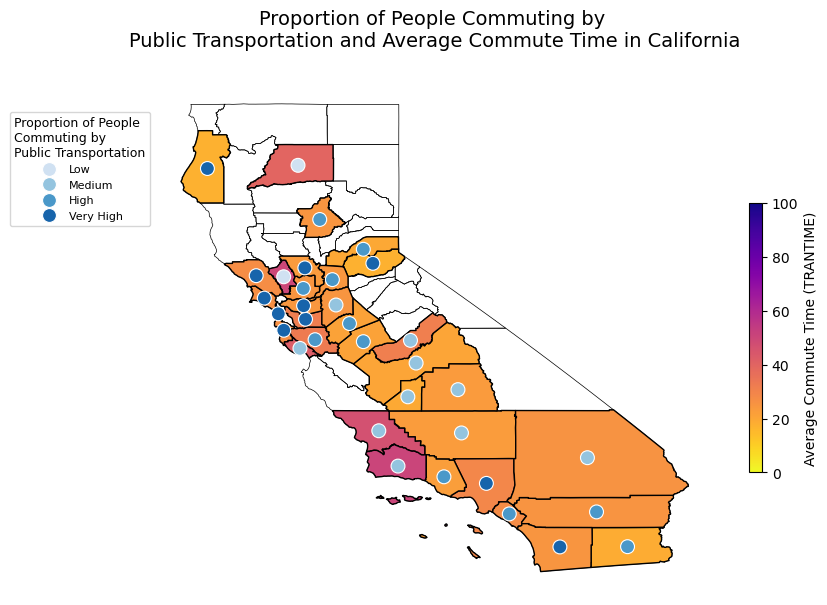

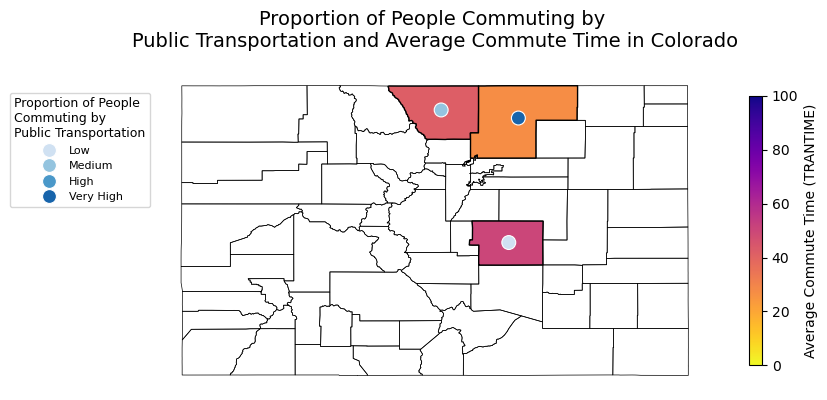

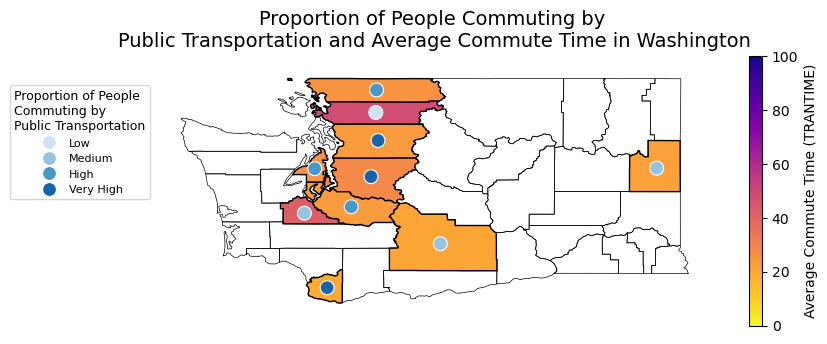

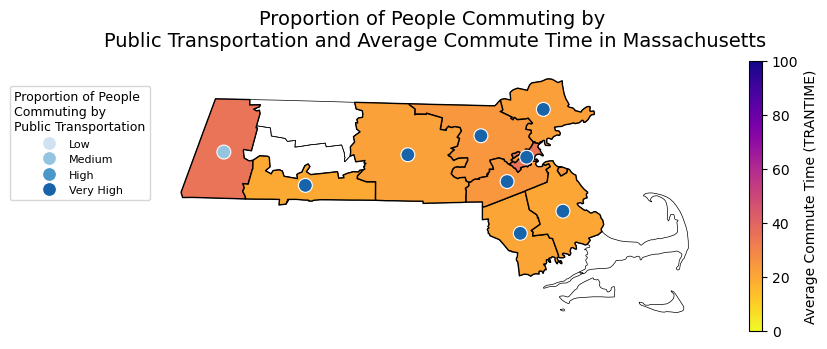

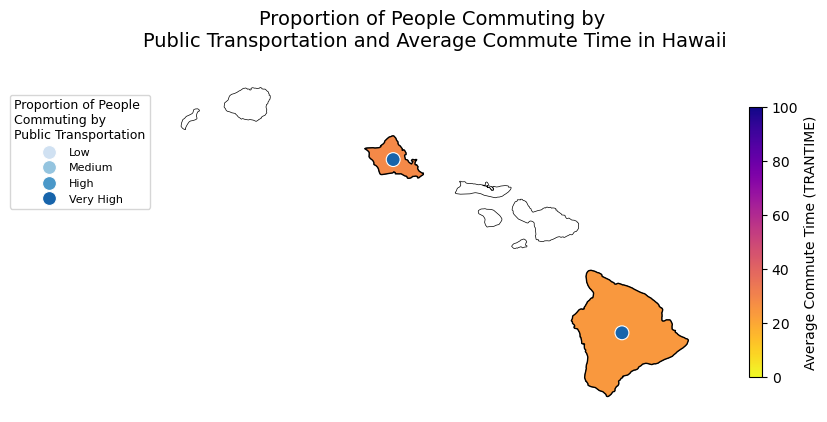

In [48]:
unique_states = filtered_county['PWSTATE2'].unique()
state_fips_to_name = {
    '1': 'Alabama', '2': 'Alaska', '4': 'Arizona', '5': 'Arkansas', '6': 'California',
    '8': 'Colorado', '9': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia', 
    '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois',
    '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', 
    '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', 
    '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', 
    '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', 
    '37': 'North Carolina', '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', 
    '42': 'Pennsylvania', '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', 
    '47': 'Tennessee', '48': 'Texas', '49': 'Utah', '50': 'Vermont', '51': 'Virginia', 
    '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
}
avg_commute_by_county = resultmergemap.groupby(
    ['PWSTATE2', 'PWCOUNTY', 'STATEFP'], as_index=False).agg({'TRANTIME': 'mean', 'geometry': 'first'})
avg_commute_by_county = gpd.GeoDataFrame(avg_commute_by_county, geometry='geometry')

for state_fip in unique_states:
    state_name = state_fips_to_name.get(str(state_fip), state_fip)
    state_county = filtered_county[filtered_county['PWSTATE2'] == state_fip]
    state_avg_commute_by_county = avg_commute_by_county\
    [avg_commute_by_county['PWSTATE2'] == state_fip]
    state_transport = county_transport[county_transport['PWSTATE2'] == state_fip]

    fig, gax = plt.subplots(figsize=(9,7))

    state_county.plot(ax=gax, edgecolor='black', facecolor='none', linewidth=0.5)

    state_avg_commute_by_county.plot(
        column='TRANTIME',  
        cmap='plasma_r',             
        edgecolor='black',             
        legend=True,               
        vmin=0, vmax=100,        
        ax=gax,
        legend_kwds={'shrink': 0.5, 'label': "Average Commute Time (TRANTIME)"}
    )                

    sns.scatterplot(
        x='Longitude', 
        y='Latitude', 
        hue='Percentile Tier',
        s=100, 
        data=state_transport,
        palette="Blues", 
        legend=True,
        ax=gax
    )
    gax.\
    set_title(f"Proportion of People Commuting by \nPublic Transportation and Average Commute Time in {state_name}", 
                  fontsize=14,y=1.05)
    plt.legend(
    bbox_to_anchor=(0, 0.95),
    fontsize=8,
    title = 'Proportion of People \nCommuting by \nPublic Transportation',
    title_fontsize=9
        
)
    plt.axis('off')
    plt.show()

This map shows the relationship between public transit usage and average commute times across top five States With The Most Expensive House Prices. In dense urban cores like Boston and San Francisco, higher public transit usage is associated with shorter commute times, reinforcing previous findings that well-connected transit networks reduce travel burdens. However, in suburban and exurban areas, even where transit reliance is high, commute times remain long, likely due to lower transit accessibility, longer travel distances, and inefficient transit options. This aligns with earlier findings that rising housing costs push lower-income workers into suburban areas, increasing commute times. Some outlier locations, such as parts of California, exhibit both high transit usage and long commutes, indicating that transit availability alone does not guarantee faster commutes—factors like transit frequency, coverage, and infrastructure quality also play crucial roles.

## Regressions

We ran these regressions to understand the relationship between house price growth and commute time, particularly how this relationship has evolved over different time periods. Economic theory suggests that rising housing costs in urban centers push lower-income workers to suburban and rural areas, increasing commute times. However, post-2020, remote work and migration trends may have altered this relationship. By estimating models across different periods, we assess whether these structural changes have influenced commuting behavior.

In [49]:

dummies = pd.get_dummies(resultmerge['Income_Category'], drop_first=False)
dummies = dummies.astype(int)  
data = pd.concat([resultmerge, dummies], axis=1)

dummies1 = pd.get_dummies(resultmerge['METRO'], drop_first=False)
dummies1 = dummies1.astype(int) 

dummies2 = pd.get_dummies(resultmerge['Work Transportation'], drop_first=False)
dummies2 = dummies2.astype(int)  

data['Pre_2010'] = (data['Year'] < 2010).astype(int)
data['Year_2010_2019'] = ((data['Year'] >= 2010) & (data['Year'] <= 2019)).astype(int)
data['Post_2020'] = (data['Year'] >= 2020).astype(int)

data = pd.concat([data, dummies1], axis=1)
data = pd.concat([data, dummies2], axis=1)
data.drop(columns=['Income_Category', 
                   'Low Income', 'METRO', 'In Central/Principal City',
                   'Vehicle'], inplace=True)
data = data.rename(columns={"TRANTIME": "Commute Time"})

In [50]:
data['const'] = 1

X1 = ['const', 'Yearly_Growth_Rate','Total Family Income']
X2 = ['const', 'Total Family Income','Yearly_Growth_Rate',
      'Not in Central/Principal City','Not in Metropolitan Area','Public Transport']
X3 = ['const','Yearly_Growth_Rate', 'Middle Income', 'High Income']
X4 = ['const', 'Yearly_Growth_Rate', 'Middle Income', 'High Income',
      'Not in Central/Principal City','Not in Metropolitan Area','Public Transport']

reg1 = sm.OLS(data['Commute Time'], data[X1], missing='drop').fit()
reg2 = sm.OLS(data['Commute Time'], data[X2], missing='drop').fit()
reg3 = sm.OLS(data['Commute Time'], data[X3], missing='drop').fit()
reg4 = sm.OLS(data['Commute Time'], data[X4], missing='drop').fit()

### Effect of House Price Growth on Commute Time (From 2006 to 2024)

In [51]:

stargazer = Stargazer([reg1, reg2, reg3, reg4])

stargazer.custom_columns(["Model 1", "Model 2", "Model 3", "Model 4"])


stargazer.dependent_variable_name("Commute Time")

stargazer.covariate_order([
    "Yearly_Growth_Rate",
    "Total Family Income",
    "Middle Income",
    "High Income",
    "Not in Central/Principal City",
    "Not in Metropolitan Area",
    "Public Transport"
])

display(HTML(stargazer.render_html()))

The regression results suggest that the negative and statistically significant coefficients for the Yearly Growth Rate (-0.042 to -0.030, p<0.01) suggest that higher house price growth in the working county is associated with shorter commute times, which may seem to contradict our hypothesis. However, this could be driven by different year effects, where economic shifts and changing work patterns (e.g., remote work post-2020) alter commuting behaviors. 

Total Family Income has a negligible impact in Model 1 but loses significance in Model 2, suggesting that it doesn’t play an important role in commute time. However, when we categorize the income group,  we find out that Middle- and High-Income workers have shorter commutes than low-income workers, with high-income workers commuting up to 0.95 minutes less. Metropolitan status is crucial, as suburban and non-metro residents face much longer commutes (7.25 minutes more for non-metro workers). Public transit significantly reduces commute time by 5.16 minutes, highlighting its importance in mitigating travel burdens. However, the low R² values (0.000–0.013) suggest that other unobserved factors strongly influence commute times.

In the next step, we will compare regression results across different year subgroups (e.g., 2010-2019 vs. 2020-2024) to assess how the relationship between house price growth and commute time has changed over time. This will help determine whether shifts in post-COVID remote work policies and migration patterns have influenced commuting behavior, particularly for lower-income and suburban workers.

### Effect of House Price Growth on Commute Time Across Different Time Periods

In [52]:

data['Growth_x_2010_2019'] = data['Yearly_Growth_Rate'] * data['Year_2010_2019']
data['Growth_x_Post2020'] = data['Yearly_Growth_Rate'] * data['Post_2020']

X1 = data[['Yearly_Growth_Rate', 'Middle Income', 'High Income', 
                     'Year_2010_2019', 'Post_2020']]


X2 = data[['Yearly_Growth_Rate', 'Middle Income', 'High Income',
               'Not in Central/Principal City', 'Not in Metropolitan Area', 
               'Public Transport', 'Year_2010_2019', 'Post_2020']]

X3 = data[['Yearly_Growth_Rate', 'Middle Income', 'High Income',
                     'Year_2010_2019', 'Post_2020', 'Growth_x_2010_2019', 'Growth_x_Post2020']]

X4 = data[['Yearly_Growth_Rate', 'Middle Income', 'High Income',
               'Not in Central/Principal City', 'Not in Metropolitan Area', 
               'Public Transport', 'Year_2010_2019', 'Post_2020',
               'Growth_x_2010_2019', 'Growth_x_Post2020']]

y = data['Commute Time']

X1 = sm.add_constant(X1)
X2 = sm.add_constant(X2)
X3 = sm.add_constant(X3)
X4 = sm.add_constant(X4)

model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()
model4 = sm.OLS(y, X4).fit()

stargazer = Stargazer([model1, model2,model3,model4])
stargazer.custom_columns(["Baseline Model", "Geographic Model", "Interaction Model", "Full Model"], [1, 1, 1,1])
stargazer.covariate_order(["const", "Yearly_Growth_Rate", "Growth_x_2010_2019", "Growth_x_Post2020",
                           "Year_2010_2019", "Post_2020", "Middle Income", "High Income",
                           "Not in Central/Principal City", "Not in Metropolitan Area",
                           "Public Transport"])
display(HTML(stargazer.render_html()))


The regression results indicate that house price growth had varying effects on commute time across different periods. The baseline model shows a small positive effect of house price growth on commute times (0.006, p<0.1), but this effect strengthened in the geographic model (0.007, p<0.05) and became highly significant in the interaction model (0.017, p<0.01). However, the full model reveals that this effect was period-specific—house price growth increased commute times before 2020 (0.124, p<0.01) but reduced them post-2020 (-0.437, p<0.01), compared to pre-2010 time, likely due to remote work adoption and migration shifts. Middle-income workers had shorter commutes than low-income workers (-0.446, p<0.01), while high-income workers also experienced reduced commute times (-0.264, p<0.01), likely benefiting from greater work flexibility. Geographic and transit factors remained crucial; non-metro residents consistently had the longest commutes (7.660, p<0.01), while public transit significantly reduced commute times (-4.939, p<0.01). The interaction terms further confirm these shifts—before 2020, house price growth was associated with increasing commute times (0.124, p<0.01), but post-2020, this effect reversed (-0.437, p<0.01), reinforcing the idea that work-from-home policies and migration patterns have fundamentally altered commuting dynamics. The improved model fit (R² = 0.020 in the full model) suggests that accounting for geographic and time interactions provides a better explanation of commuting behavior.

Finally, we select the full model, which incorporates time-fixed effects, geographic controls, and interaction terms, as our preferred specification because it provides the most comprehensive view of how commuting behavior has evolved over time. By including pre-2010 (baseline), 2010-2019, and post-2020 periods within a single model, we capture both long-term commuting trends and the structural shifts brought about by post-pandemic changes such as remote work adoption. The improved model fit (R² = 0.020) compared to earlier specifications suggests that incorporating geographic and time-based interactions provides a stronger explanatory framework, making this model particularly relevant to our research question on the evolving relationship between housing markets and commuting behavior.

#### From our results, we see that
$
\begin{aligned}
\hat{\beta}_0 &= 28.123 \\
\hat{\beta}_1 &= 0.012  \\
\hat{\beta}_2 &= 0.124  \\
\hat{\beta}_3 &= -0.437  \\
\hat{\beta}_4 &= 0.734  \\
\hat{\beta}_5 &= 0.358  \\
\hat{\beta}_6 &= -0.446  \\
\hat{\beta}_7 &= -0.264  \\
\hat{\beta}_8 &= -0.867  \\
\hat{\beta}9 &= 7.660  \\
\hat{\beta}{10} &= -4.939
\end{aligned}
$

The positive $\hat{\beta}_1$ = 0.012 estimate suggests that house price growth had a small effect on increasing commute times, implying that rising housing costs forced workers to relocate farther from job centers, but no huge impact.

The p-value of 0.000 for $\hat{\beta}_1$ confirms statistical significance (p < 0.05), indicating that house price growth meaningfully influenced commute time.

The $R^2$ value of 0.020 suggests that 2% of the variation in commute time is explained by house price growth and other included variables, highlighting the presence of unobserved factors.

Using our parameter estimates, we can now write our estimated relationship as:

$
\begin{aligned}
\widehat{Commute Time}_i &= 28.123 
+ 0.012 \times \text {Yearly Growth Rate}_i \\
&+ 0.124 \times \text {Growth} \times \text{Year}_{2010-2019} 
- 0.437 \times \text {Growth} \times \text{Post}_{2020} \\
&+ 0.734 \times \text{Year}_{2010-2019} 
+ 0.358 \times \text{Post}_{2020} \\
&- 0.446 \times \text {Middle Income}_i 
- 0.264 \times \text {High Income}_i \\
&- 0.867 \times \text {Not in Central/Principal City}_i 
+ 7.660 \times \text {Not in Metropolitan Area}_i \\
&- 4.939 \times \text {Public Transport}_i 
\end{aligned}
$

These results indicate that commute times are affected by a combination of income levels, geographic factors, and transportation infrastructure, with public transport significantly reducing commute times while suburban and non-metro areas experience longer travel durations. The interaction terms show that house price growth had different impacts in different periods, suggesting structural changes in commuting behavior over time.

# Final Project

## Potential Data to Scrape

We scrapt the data from https://santiagofrias.com/ranked-the-u-s-cities-with-the-most-vacant-offices/. From the main body of the webpage, I extracted the table titled “Ranked: The U.S. Cities with the Most Vacant Offices,” which contains the following variables: Rank (ordinal position of the city); City (e.g., San Francisco, New York City); State (e.g., California, New York); Change in Vacancy Rates (Q4 2019 vs. Q1 2023) measured in percentage points (p.p.).

This scraped table provides a valuable macro-level indicator of how urban economic geography shifted in response to the COVID-19 pandemic, as captured by changes in office vacancy rates between 2019 and 2023. Office vacancy rates surged in major U.S. cities as remote work reduced the demand for centralized workspaces. We incorporate this data to assess whether the pandemic altered the relationship between workplace housing price growth and commuting times. Specifically, we are interested in testing whether higher post-COVID office vacancy rates—serving as a proxy for reduced physical presence at workplaces—are associated with changes in commuting patterns. Our hypothesis is that COVID-19 fundamentally changed the link between job location and commute time, potentially flipping the traditional relationship between house price growth in job centers and longer commute times. We supposed that workers in cities experiencing larger increases in office vacancy rates between 2019 and 2023 should exhibit greater reductions in average commute times, as remote work and declining central business district activity reduce the need for daily commuting.

We matched the scraped vacancy rate data with our commute dataset using city and state as linking keys. To enable integration with county-level data, we appended StateFIPS and CountyFIPS codes for each city and merged this with a subset of our main dataset containing average commute times aggregated by county and year. We then calculated the percentage point change in average commute time between 2019 and 2024 for each city’s corresponding county. This allowed us to directly compare shifts in office vacancy rates with changes in commuting patterns, which we visualized using a scatter plot to explore how post-COVID vacancy dynamics may relate to spatial commute outcomes.

## Potential Challenges

Scraping this source presented several challenges. First, the website does not include standardized geographic identifiers like FIPS codes, which necessitates manual or approximate matching to county-level data using city and state names—introducing potential ambiguity, especially for cities spanning multiple counties (e.g., New York City). Second, the data is a one-time snapshot comparing office vacancy rates between Q4 2019 and Q1 2023, so it cannot be collected continuously over time unless the website is updated regularly. As such, there’s no need to run a scraper on a recurring basis. While I was able to scrape and visualize the full table, I am limited to static comparisons rather than time-series trends. Nonetheless, the existing data allows for meaningful visual analysis of the relationship between vacancy changes and commute outcomes.

## Scraping Data from a Website

In [54]:
import requests
web_url = 'https://santiagofrias.com/ranked-the-u-s-cities-with-the-most-vacant-offices/'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
response = requests.get(web_url, headers=headers)

In [55]:
from bs4 import BeautifulSoup
soup_object = BeautifulSoup(response.content)

In [56]:
data_table = soup_object.find_all('table', class_='table \
table-striped table-bordered table-hover')[0]

In [57]:
all_values = data_table.find_all('tr')

In [58]:
rows = data_table.find_all('tr')

# Initialize empty DataFrame
vacancy_df = pd.DataFrame(columns=['Rank', 'City', 'State', 'Change'])

# Extract rows
ix = 0
for row in rows[1:]:  # Skip header
    values = row.find_all('td')
    if len(values) == 4:
        rank = values[0].text.strip()
        city = values[1].text.strip()
        state = values[2].text.strip()
        change = values[3].text.strip()

        vacancy_df.loc[ix] = [rank, city, state, change]
        ix += 1

# Save to CSV
vacancy_df.to_csv("vacancy_rate_changes.csv", index=False)

## Visualizing the Scraped Dataset

In [59]:
avg_commute_by_county = resultmergemap\
.groupby(
    ['PWSTATE2', 'PWCOUNTY', 'STATEFP', 'Year'], as_index=False
).agg({'TRANTIME': 'mean', 'geometry': 'first'})

In [60]:
# Step 1: Filter for 2019 and 2024
filtered_commute = avg_commute_by_county[avg_commute_by_county['Year'].isin([2019, 2023])]

# Step 2: Pivot table so each county has commute times for both years
pivot_commute = filtered_commute.pivot_table(
    index=['STATEFP', 'PWCOUNTY'],
    columns='Year',
    values='TRANTIME'
).reset_index()

# Optional: Rename columns for clarity
pivot_commute.columns.name = None
pivot_commute = pivot_commute.rename(columns={2019: 'TRANTIME_2019', 2023: 'TRANTIME_2023'})

# Step 3: Calculate percentage change
pivot_commute['Pct_Change'] = ((pivot_commute['TRANTIME_2023'] - pivot_commute['TRANTIME_2019']) / 
                               pivot_commute['TRANTIME_2019']) * 100


In [61]:
fips_lookup = {
    "San Francisco": {"StateFIPS": "06", "CountyFIPS": "075"},
    "New York City (Midtown South)": {"StateFIPS": "36", "CountyFIPS": "061"},  # Manhattan
    "Austin": {"StateFIPS": "48", "CountyFIPS": "453"},  # Travis County
    "Seattle": {"StateFIPS": "53", "CountyFIPS": "033"},  # King County
    "Salt Lake City": {"StateFIPS": "49", "CountyFIPS": "035"},  # Salt Lake County
    "New York City (Downtown)": {"StateFIPS": "36", "CountyFIPS": "061"},
    "Phoenix": {"StateFIPS": "04", "CountyFIPS": "013"},  # Maricopa
    "Columbus": {"StateFIPS": "39", "CountyFIPS": "049"},  # Franklin
    "Raleigh-Durham": {"StateFIPS": "37", "CountyFIPS": "063"},  # Durham County (simplified)
    "New York City (Midtown)": {"StateFIPS": "36", "CountyFIPS": "061"},
}

# Apply mapping
vacancy_df["StateFIPS"] = vacancy_df["City"].map(lambda x: fips_lookup.get(x, {}).get("StateFIPS"))
vacancy_df["CountyFIPS"] = vacancy_df["City"].map(lambda x: fips_lookup.get(x, {}).get("CountyFIPS"))

In [62]:
vacancy_df["CountyFIPS"] = vacancy_df["CountyFIPS"].apply(lambda x: str(x).zfill(3))
vacancy_df["StateFIPS"] = vacancy_df["StateFIPS"].apply(lambda x: str(x).zfill(2))

commute_df = pivot_commute.copy()
commute_df["CountyFIPS"] = commute_df["PWCOUNTY"].apply(lambda x: str(x).zfill(3))
commute_df["StateFIPS"] = commute_df["STATEFP"].apply(lambda x: str(x).zfill(2))

merged_df = pd.merge(
    vacancy_df,
    commute_df,
    how="left",
    on=["StateFIPS", "CountyFIPS"]
)


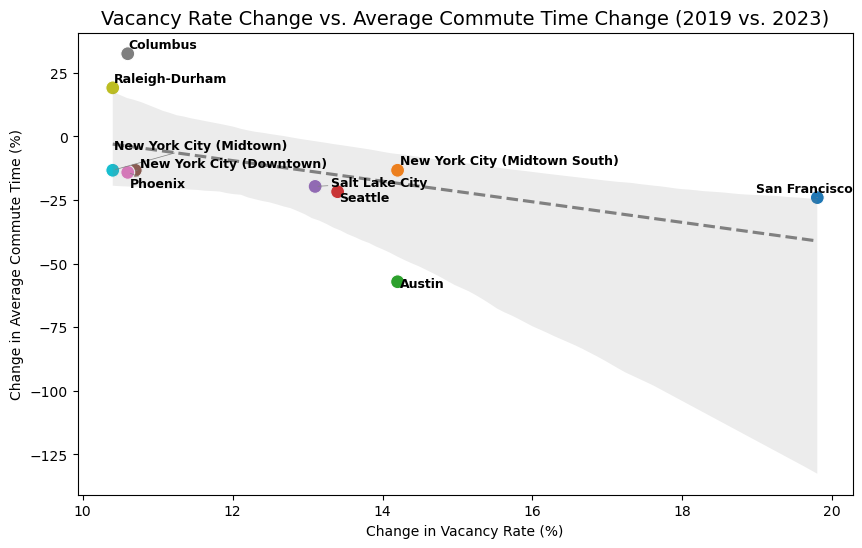

In [63]:
# Extract numerical vacancy rate change
merged_df['Vacancy_Change'] = merged_df['Change'].\
str.extract(r'(\d+\.\d+|\d+)').astype(float)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Vacancy_Change', 
                y='Pct_Change', hue='City', s=100, legend=False)
sns.regplot(data=merged_df, x='Vacancy_Change', y='Pct_Change', 
            scatter=False, color='gray', line_kws={"linestyle": "dashed"})

# Set labels and title BEFORE adjusting text
plt.title("Vacancy Rate Change vs. Average \
Commute Time Change (2019 vs. 2023)", fontsize=14)
plt.xlabel("Change in Vacancy Rate (%)")
plt.ylabel("Change in Average Commute Time (%)")


# Create labels and optimize positions
texts = []
for i, row in merged_df.iterrows():
    texts.append(plt.text(row['Vacancy_Change'],
                          row['Pct_Change'], row['City'], 
                          fontsize=9,fontweight='bold'))

adjust_text(
    texts,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle="-", color='gray', lw=0.5)
)
plt.savefig("vacancy.png", dpi=300, bbox_inches='tight')
plt.show()

This scatter plot shows the relationship between the change in office vacancy rates and the percentage change in average commute times across major U.S. cities from 2019 to 2023. Each point represents a city, and the fitted regression line reveals a negative correlation: cities that experienced larger increases in office vacancy rates tended to also see greater reductions in average commute times. This pattern is consistent with the new hypothesis we suggest from the regression that the COVID-19 pandemic altered the spatial dynamics of work and commuting. As remote work became more prevalent and office demand declined, especially in high-cost urban centers like San Francisco and New York, commuting pressures eased, particularly for lower-income workers who may have previously lived farther from job centers due to affordability constraints. For example, San Francisco, with the highest rise in office vacancy (+19.8 percentage points), saw a notable decline in average commute time, while Austin, despite a slightly lower vacancy increase, experienced the largest drop in commute duration—suggesting deeper affordability or relocation effects. Conversely, cities like Columbus and Raleigh-Durham, which had modest vacancy increases, saw commute times rise, reflecting localized factors. Overall, this figure provides macro-level evidence that shifts in urban office demand during the pandemic contributed to changes in commuting patterns, offering structural context to complement individual-level survey results in our study.

## Regression Tree

We implement a regression tree model to capture nonlinear interactions and threshold effects in commute time. The model partitions the feature space by recursively splitting it into smaller regions that minimize the mean squared error (MSE). At each step, the algorithm selects the optimal variable and split point to reduce prediction error:

$$
\min_{j,s} \left[  \sum_{i: x_{i,j} \leq s, x_i \in R1}
(y_i - \hat{y}{R1})^2 +  \sum{i: x_{i,j} > s, x_i \in R2}
(y_i - \hat{y}_{R2})^2 \right]
$$

Splitting continues until a stopping criterion is met, such as a minimum number of observations per node or a maximum tree depth. To avoid overfitting, we apply a pruning step that balances fit and model complexity:

$$
\min_{\text{tree} \subset T} \sum (\hat{f}(x)-y)^2 + \alpha|\text{terminal nodes in tree}|
$$

First, we conduct the regression tree model with all X variables.

In [77]:
X = data.drop(["PWSTATE2", "PWCOUNTY", "COUNTYFIP","STATEFIP",
               "Commute Time","Work Transportation",
               "DEPARTS_CATEGORY","DEPARTS",'RegionName',
               'State', 'Metro'], axis=1).copy()
for col in list(X):
    X[col] = X[col].astype(float)

In [78]:
data["Commute Time"] = y

In [67]:
from sklearn import tree
sqft_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)

In [68]:
y_pred_tree = sqft_tree.predict(X)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree))

Mean Squared Error: 507.67071886876755


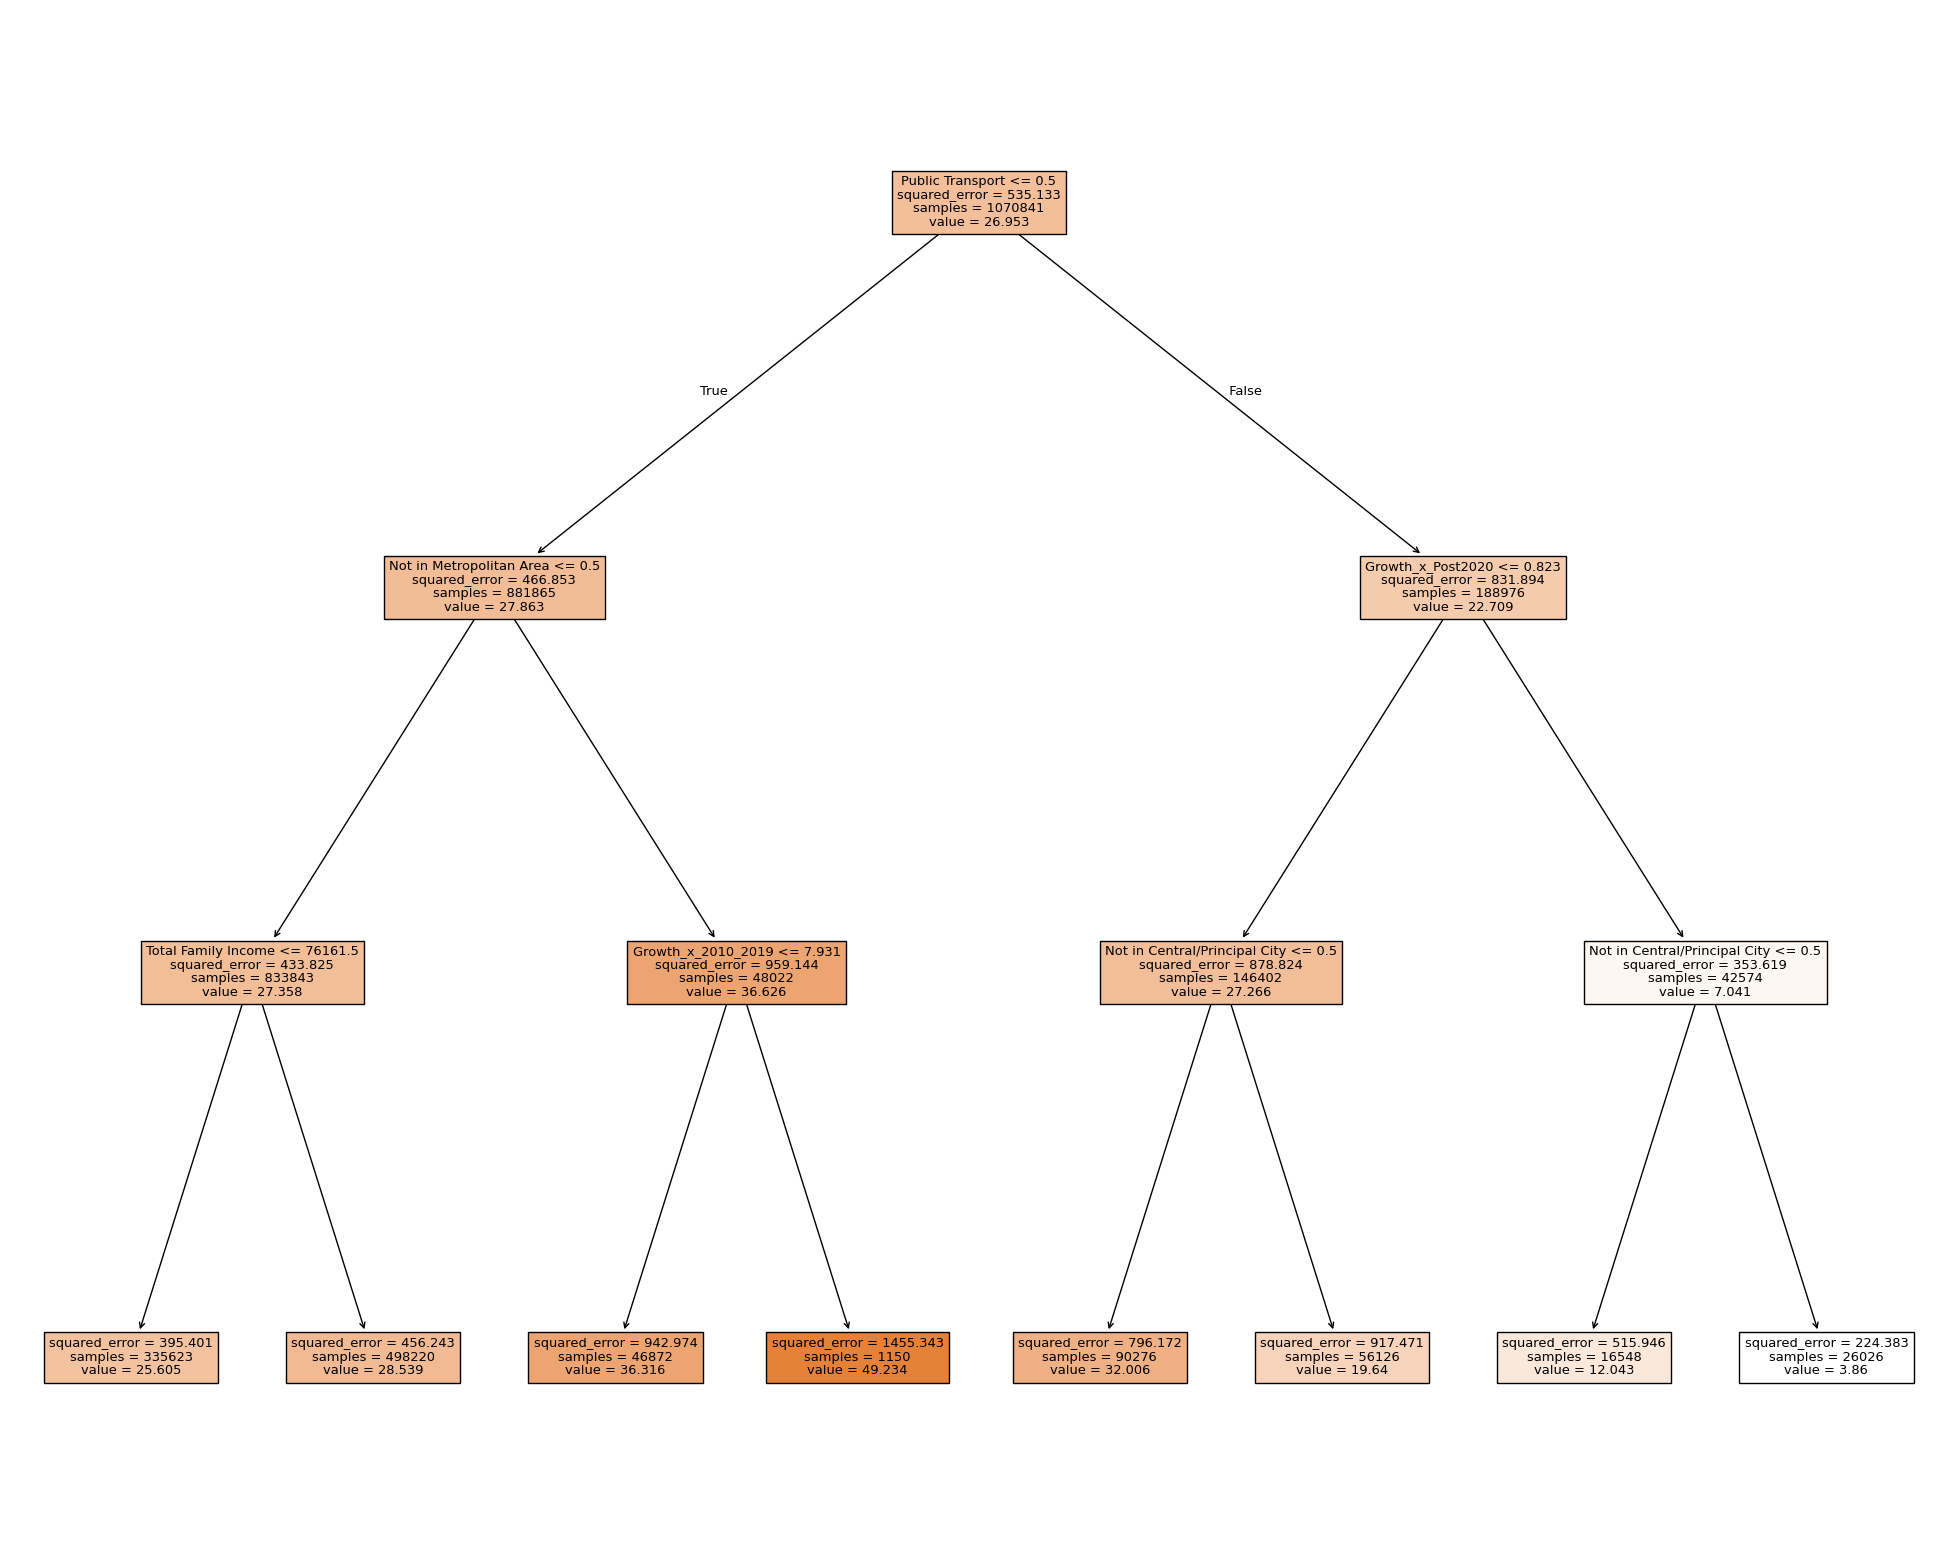

In [80]:
sqrf_fig = plt.figure(figsize=(25,20))
sqrf_fig = tree.plot_tree(sqft_tree, feature_names=X.columns, filled=True)
plt.savefig("regression_tree.png", dpi=300, bbox_inches='tight')

This regression tree shows key nonlinear patterns in commute time. It first splits on Public Transport, indicating that commute Transportation is the most important predictor. Among those not using public transit, the next most influential variable is a residential location, with a split at Not in a Metropolitan Area, followed by Total Family Income (with a threshold of $76,161). For transit users, the tree identifies a critical threshold at Growth × Post2020 ≤ 0.823, closely aligning with the OLS finding that post-pandemic housing price growth strongly affects commute behavior. 

Then, we remove the interaction terms and conduct a new regression tree model.

In [79]:
X1 = data.drop(["PWSTATE2", "PWCOUNTY", "COUNTYFIP",
                "STATEFIP","Commute Time","Work Transportation",
                "DEPARTS_CATEGORY","DEPARTS",'RegionName', 'State', 
                'Metro','Growth_x_2010_2019', 'Growth_x_Post2020'], axis=1).copy()
for col in list(X1):
    X1[col] = X1[col].astype(float)

In [71]:
from sklearn import tree
sqft_tree1 = tree.DecisionTreeRegressor(max_depth=3).fit(X1,y)

In [72]:
y_pred_tree1 = sqft_tree1.predict(X1)
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree1))

Mean Squared Error: 507.66803753719404


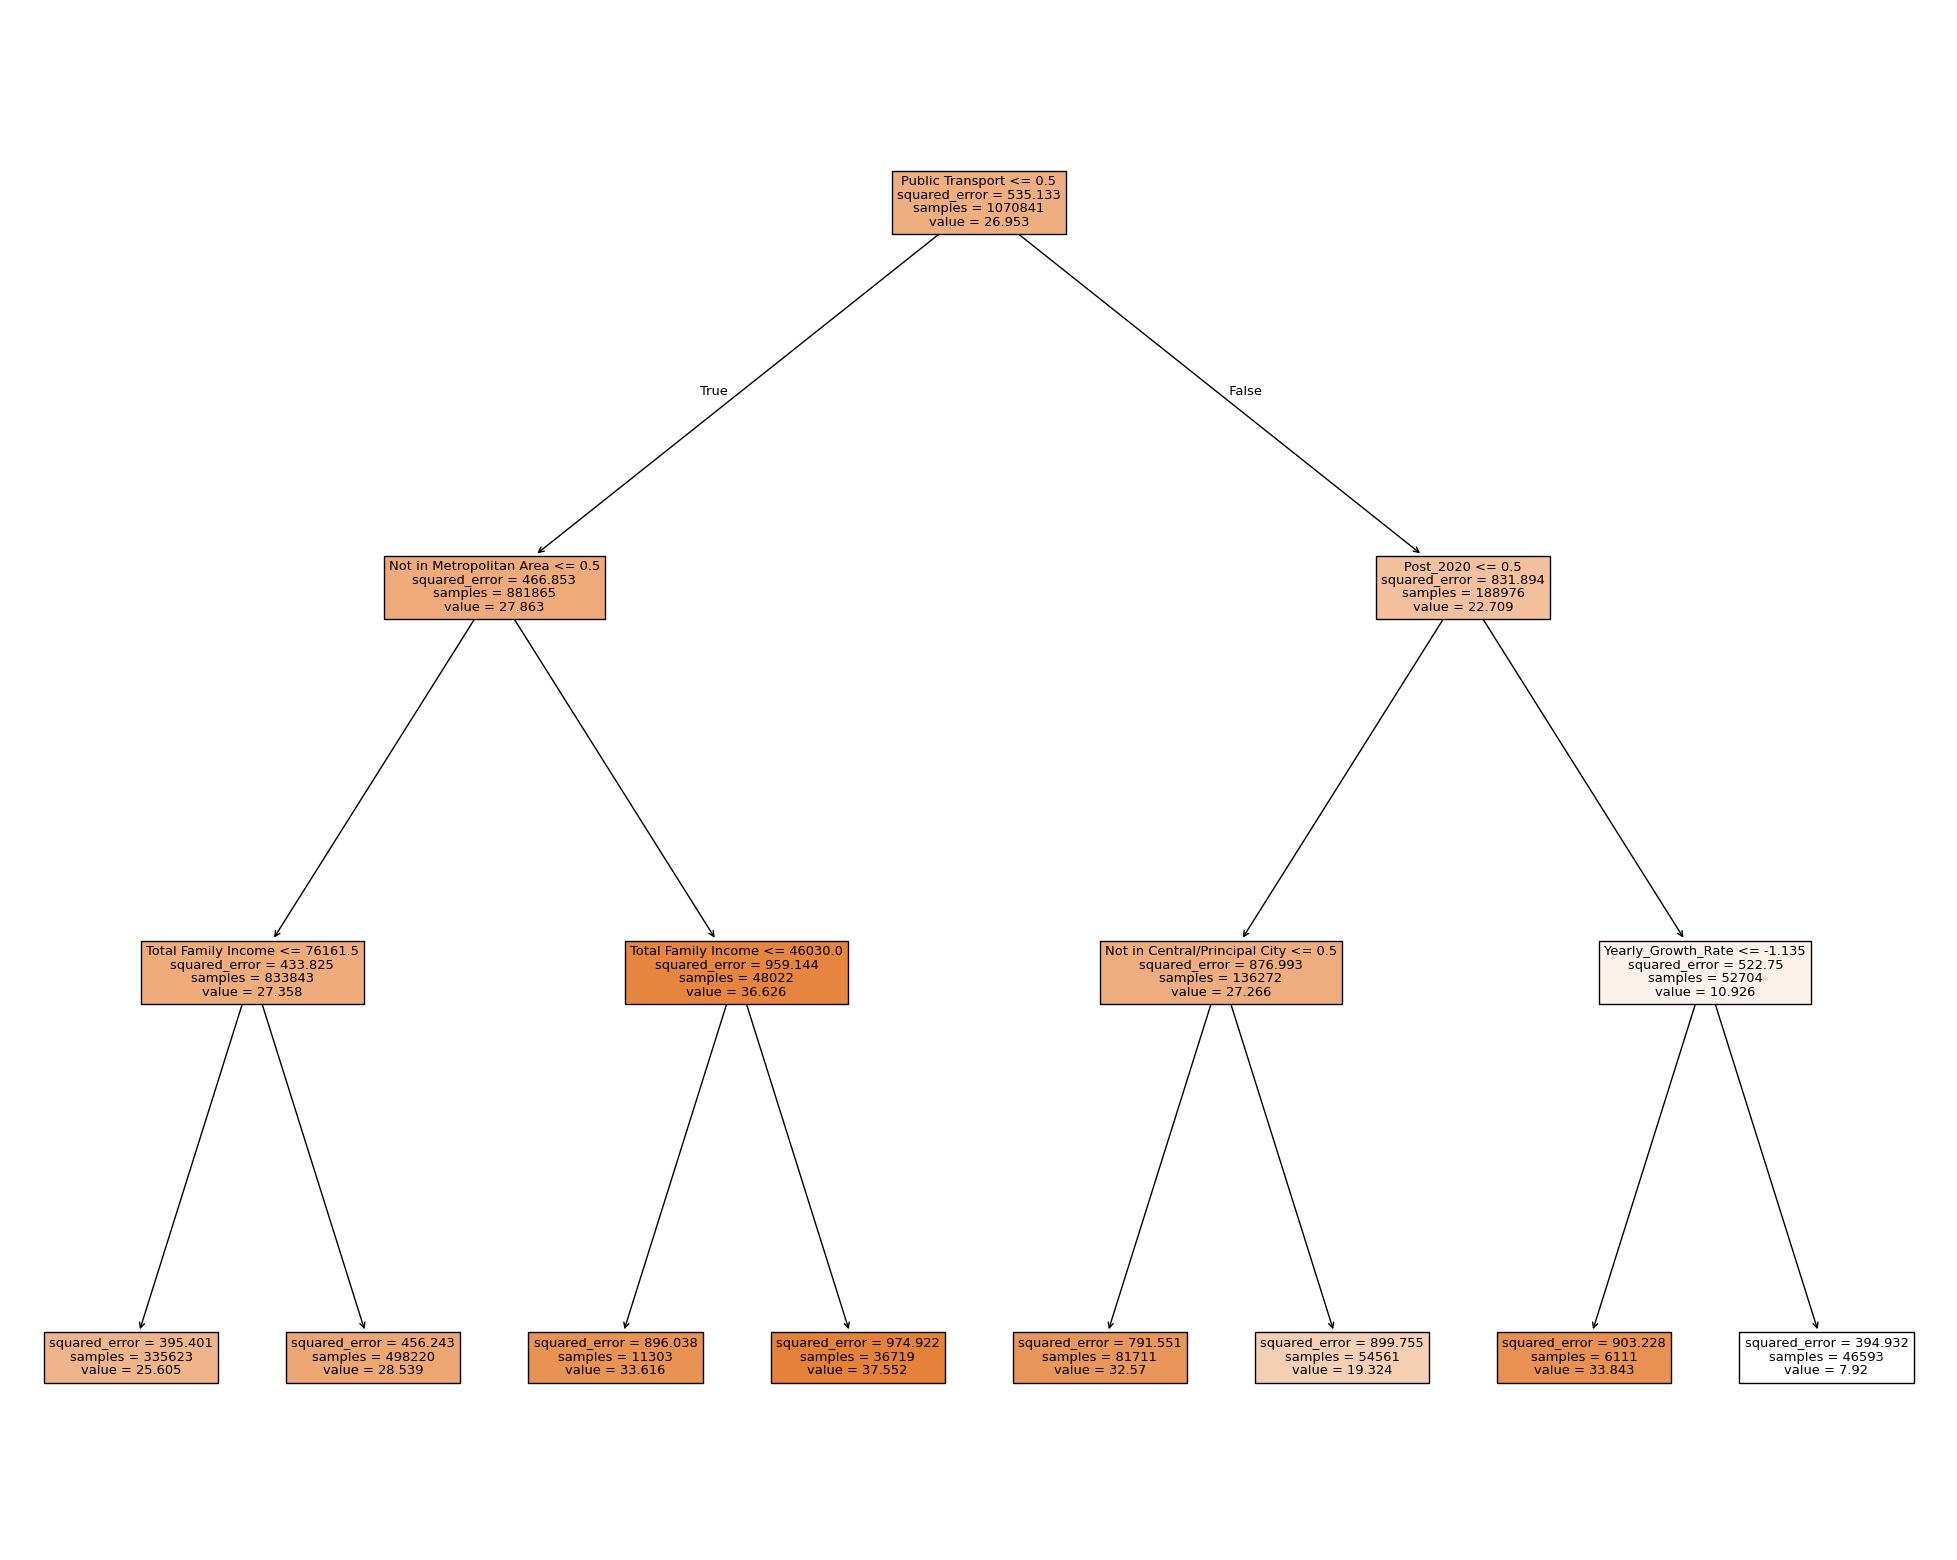

In [73]:
sqrf_fig1 = plt.figure(figsize=(25,20))
sqrf_fig1 = tree.plot_tree(sqft_tree1, feature_names=X1.columns, filled=True)

This regression tree shows that public transport use is the strongest predictor of commute time, with non-users generally commuting longer. For those not using public transport, commute times vary by metro status and income, with lower-income urban residents having the shortest commutes. Among transit users, post-2020 patterns shift dramatically—people in areas with declining housing prices have notably shorter commutes, likely due to remote work.

We can find out that the mean square error of the two regression tree models is almost similar, the regression tree model removing interaction terms has a slightly smaller MSE (507.67071886876755>507.66803753719404).

## Random Forest

We incorporate Random Forest to address a key limitation of Bagging: the similarity between trees. In Bagging, trees often end up splitting on the same highly predictive variables—like age—leading to correlated models and diminishing the benefits of ensembling. Random Forest solves this by adding a small but effective twist: at each split, it randomly selects a subset of predictor variables and chooses the best split only from this subset. This randomness encourages greater variation among the trees, making the ensemble more diverse and reducing overfitting. By forcing the model to explore different features, Random Forest improves predictive performance and captures more complex patterns in the data.

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
regr_RF = RandomForestRegressor(max_features=5, random_state=1).fit(X, y)

pred = regr_RF.predict(X)
mean_squared_error(y, pred)

111.8529797616064

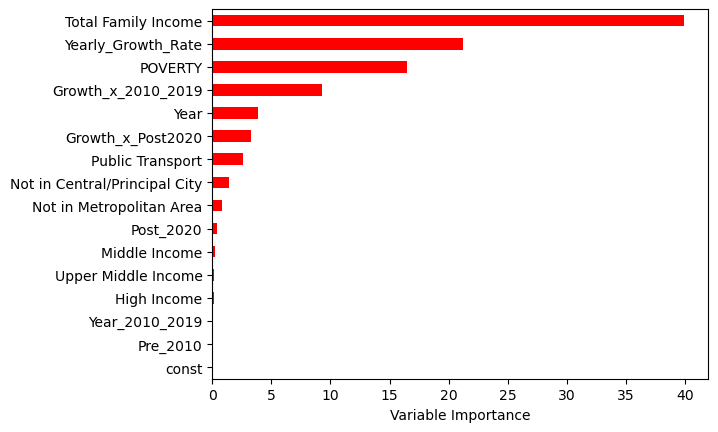

In [76]:
Importance = pd.DataFrame({'Importance':regr_RF.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.savefig("randomforest.png", dpi=300, bbox_inches='tight')
plt.gca().legend_ = None

The Importance Matrix from Random Forest highlights which features most strongly predict commute time. Total Family Income stands out as the most influential variable, suggesting that income plays a major role in shaping commuting behavior—likely through its effect on residential location, job access, and transportation options. The yearly Growth Rate of housing prices ranks second, supporting our idea that rising housing costs contribute to longer or more complex commutes. Poverty status and pre-pandemic price growth (Growth × 2010–2019) are also key predictors, pointing to the compounding effects of affordability stress. Moderate importance is given to variables like Public Transport, urban/rural location, and post-2020 period, indicating that infrastructure and timing influence travel patterns. In contrast, categorical income and time dummies contribute little, possibly because their effects are better captured by the continuous variables. Overall, the  Importance Matrix emphasizes economic vulnerability and accessibility in shaping commute outcomes.

Compared with the regression tree model, the MSE of the random forest is much smaller than the regression tree, which indicates that the prediction power of the random forest model is much larger than the regression tree model.

## OLS vs ML

Comparing the OLS and ML results, we find out that both models identify housing price growth and income as critical determinants of commute time. In the OLS model, the interaction terms (e.g., Growth × Post-2020) show how the effect of housing prices shifts over time, particularly before and after the pandemic. This is echoed in the regression tree, where Yearly Growth Rate and Growth × post-2020 are among the top variables in importance. 

While the regression tree and random forest find patterns that are not captured by the OLS model. Most notably, the regression tree detects nonlinear relationships and interaction thresholds—for example, commute time changes sharply when Total Family Income drops below $46,030 or when after the year 2020 and the Yearly Growth Rate is below –1.135. These splits suggest context-specific effects that vary across population subgroups, which OLS cannot identify unless interaction terms are manually specified.

Moreover, the regression tree prioritizes Public Transport as the most influential factor in explaining commute time, challenging our initial hypothesis that house price growth would be the primary driver. In this model, the Yearly Growth Rate appears less predictive, suggesting housing dynamics may not directly shape commute patterns. However, the random forest model ranks Total Family Income as the most important predictor, with house price growth still playing a significant role—aligning more closely with our original hypothesis.

In contrast, the OLS model offers average treatment effects and interpretable coefficients but may obscure heterogeneous effects or non-monotonic relationships. Thus, the machine learning model uncovers behavioral thresholds and complex interactions not visible in OLS, enriching our understanding of how housing growth and inequality interact to shape commuting outcomes.

## Conclusion and Future Work

Our findings show a huge shift in the relationship between house price growth and commute time after 2020. Before the pandemic, rising housing costs were associated with longer commutes, particularly for lower-income workers moving to more affordable suburban or rural areas. After 2020, however, this relationship reversed—higher house price growth was linked to shorter commutes, likely due to the expansion of remote work and migration to less congested areas. Public transit users experienced the most significant reductions in commute time, and high-income workers consistently enjoyed shorter commutes. This flip may caused by COVID-19, as the widespread adoption of remote work led to lower needs for office commutes. The observed correlation between higher vacancy rates and shorter commute times supports the hypothesis that remote work fundamentally reshaped travel patterns, contributing to the post-2020 reversal in the relationship between house price growth and commute time.

Machine learning results complement our regression findings by revealing key nonlinear patterns. The regression tree ranked Public Transport as the most important predictor, while the random forest model highlighted Total Family Income and house price growth among the top factors—supporting our original hypothesis. These methods also uncovered threshold effects and variable interactions that are not captured by OLS. Future work will assess the long-term stability of these shifts as remote work policies evolve and housing markets stabilize. Policymakers should consider these dynamics when planning for equitable infrastructure and sustainable urban development in a post-pandemic landscape.

# Reference

Allen, J., & Farber, S. (2020). Suburbanization of transport poverty. Annals of the American Association of Geographers, 110(6), 1356-1372. https://doi.org/10.1080/24694452.2020.1859981

Berke, A., Doorley, R., Alfonso, L., & Larson, K. (2022). Preserving Sustainability Gains of the COVID-19 Pandemic: A Case Study of MIT Campus Commuting. Transportation Research Record: Journal of the Transportation Research Board.

Blumenberg, E., & Wander, M. (2023). Housing affordability and commute distance. Urban Geography, 44(7), 1454-1473. https://doi.org/10.1080/02723638.2022.2087319!

Blumenberg, E., & King, H. R. (2019). Low-income workers, residential location, and the changing commute in the United States. Built Environment, 45, 563-581. https://doi.org/10.2148/benv.45.4.563

Frias, S. (2023, April 17). Ranked: The U.S. cities with the most vacant offices. SantiagoFrias.com. https://santiagofrias.com/ranked-the-u-s-cities-with-the-most-vacant-offices/

Hensher, D.A., Wei, E., Beck, M.J., & Balbontin, C. (2021). The impact of COVID-19 on cost outlays for car and public transport commuting - The case of the Greater Sydney Metropolitan Area after three months of restrictions. Transport Policy, 101, 71-80.

Hochstenbach, C., & Musterd, S. (2016). Changing urban geographies through boom and bust periods: Gentrification and the suburbanization of poverty. CUS Working Paper Series; No. 17. Centre for Urban Studies, University of Amsterdam. http://urbanstudies.uva.nl/working-papers/working-papers/workingpapers/content/folder/working-paper-series-no.17.html

Kogus, A., Gal-Tzur, A., & Shiftan, Y. (2023). Modelling the Long-Term Expected Impact of the Covid-19 Crisis on Commute and Telecommute. Transportation Research Record: Journal of the Transportation Research Board.

Mohammadi, M. Y., Rahimi, E., Davatgari, A., Javadinasr, M., Mohammadian, A. K., BhagatConway, M. W., Salon, D., Derrible, S., Pendyala, R. M., & Khoeini, S. (2023). Examining the persistence of telecommuting after the COVID-19 pandemic. Transportation Letters, 15(6), 608-621. https://doi.org/10.1080/19427867.2022.2077582

Ruggles, S., Flood, S., Sobek, M., Backman, D., Chen, A., Cooper, G., Richards, S., Rodgers, R., & Schouweiler, M. (2024) IPUMS USA: Version 15.0 [dataset] Minneapolis, MN: IPUMS https://doi.org/10.18128/D010.V15.0

Shibayama, T., Sandholzer, F., Laa, B., & Brezina, T. (2021). Impact of COVID-19 lockdown on commuting. European Journal of Transport and Infrastructure Research.

Travers, M. (2024, March 5). A psychologist explains the concept of time poverty and offers 4 fixes. Forbes. Retrieved from https://www.forbes.com/sites/traversmark/2024/03/05/a-psychologist-explains-the-concept-of-time-poverty-and-offers-4-fixes/

